# Multilabeling Task for Fashion


## 5.18.2019

# Introduction

Clothing in various cultures reflects many things such as
age, social status, lifestyle and gender. Apparel is also an
important descriptor in identifying different persons. However, understanding fashion is still a very complicated task for computer vision. The field has applications in
social media and e-commerce. We focus on several tasks within the fashion classification umbrella: 

1.   Multilabel classification of clothing attributes
2.   Object detection

Depending on the specific application of fashion classification, the most relevant problems to solve will be different. We will focus on optimizing fashion classification for the
purposes of annotating images and discovering the temporal fashion patterns.

Our pipeline is as follows: given a query image from streetsytle database, 

1.   Detect the person and crop images, record the bounding boxes coordinates,
2.   Predict the clothing attributes. 

The dataset we are using is streetsytle27k (http://streetstyle.cs.cornell.edu/). More detailed exploration and preprocess work can be find in the *preprocess_data.ipython* notebook. 

We report accuracy measurements range from 66% to 85% for different attributes.




# Basic setting

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from tqdm import tqdm
import pandas as pd

import sys

sys.path.append('/content/gdrive/My Drive/colab')
from plotting_fns import *

np.random.seed(1)

In [0]:
path = Path('/content/gdrive/My Drive/colab/data/db/')

labels = pd.read_csv(path/'labels.csv')

device = torch.device('cuda')

categories = ['clothing_pattern', 'major_color', 'sleeve_length', 'neckline_shape', 'clothing_category', 'multiple_layers']
labels.loc[labels['label'].isna(), 'label'] = ''

assert not (any(labels['url'].isna()) or any(labels['label'].isna()) or any(labels['test'].isna()) )

In [0]:
#!ls -l 'data/cropped'

total 2680
drwxr-xr-x 2 root root  143360 May 20 16:59 test
drwxr-xr-x 2 root root 2600960 May 20 16:33 train


We have a total of 40 attributes such as color, sleeve length, neckline, etc which have been labeled in our dataset.

In [0]:
#use the orginal crop in the database
crop_imgs = True
bs = 64
if crop_imgs:
    path = 'data/cropped'
else:
    path = 'data/all'
data = (ImageList.from_df(labels[~labels['test']], path, folder='train')
        .split_from_df(col='valid') 
        .label_from_df(label_delim=';')  
        .transform(get_transforms(), size=299)  
        .databunch(bs=bs, device=device).normalize(imagenet_stats))

print(f'Number of classes: {data.c}, training examples: {len(data.train_ds)}')

Number of classes: 40, training examples: 16722


We ramdomly pick several cropped images to plot:

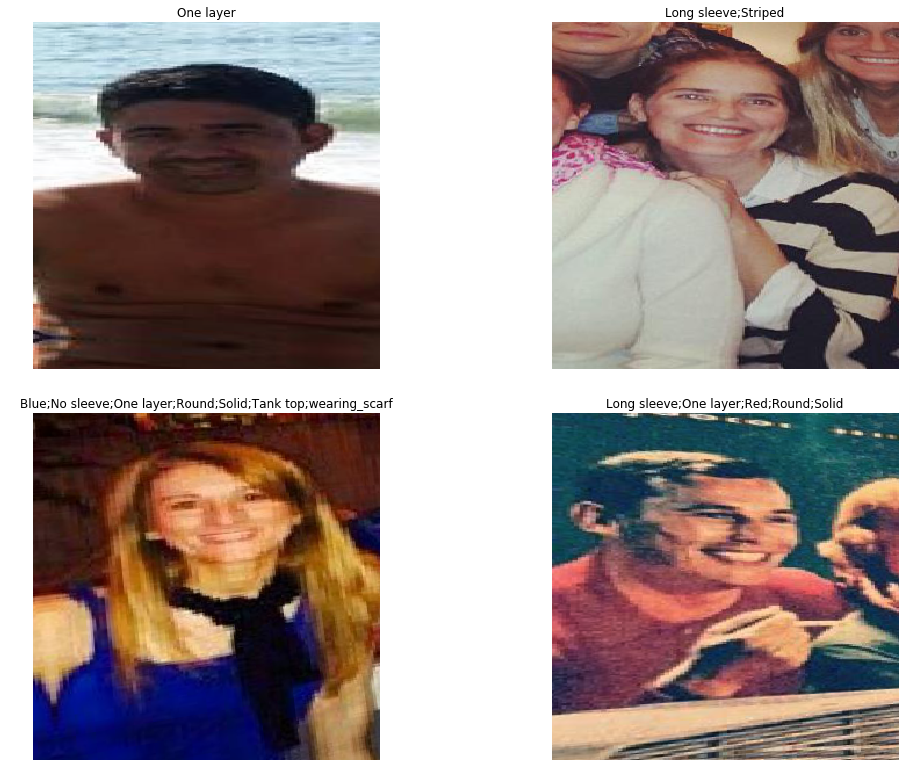

In [0]:
data.show_batch(rows=2, figsize=(15,11))

Reweights

In [0]:
def get_cats(df, col):
    '''
    Returns unique (non-NA) values for column `col` in dataframe `df`
    '''
    na_flag = df[col].isna()
    return df.loc[~na_flag, col].unique()
    
def get_cat_idxs(cats, data_classes):
    '''
    Returns indices `data_classes` that appear in `cats`.
    '''    
    cats, data_classes = np.array(cats), np.array(data_classes)
    assert len(cats.shape) == 1 and len(data_classes.shape) == 1
    return np.where((data_classes[None, :] == cats[:, None]))[1]

def get_y_totals(data):
    '''Counts the label occurence for training data in databunch `data`. (Sums up y values)'''    
    with torch.no_grad():
        sums = [yb.sum(dim=0) for _, yb in tqdm(data.train_dl, position=0)]
        return torch.stack(sums).sum(dim=0)

In [0]:
y_totals = get_y_totals(data)
y_totals

100%|██████████| 2090/2090 [03:59<00:00,  8.74it/s]


tensor([ 4215.,  1516.,   254.,    18.,  1643.,   600.,  5162.,  2482.,   854.,
          325.,  8661.,  1608.,  5673.,  2302., 10297.,   107.,  2956.,   425.,
          343.,   104.,   749.,  6358.,  2975.,  4634., 10223.,   166.,   711.,
          737.,   562.,  3008.,   884.,  1306.,  2904.,   292.,  4620.,   520.,
         2185.,  1439.,  4587.,   933.], device='cuda:0')

In [0]:
def cat_weight(y_totals, cat_col, labels, data_classes):
    '''Gets updated weights for a label category, based on relative frequency in that category.'''
    idxs = get_cat_idxs(get_cats(labels, cat_col), data_classes)
    sub = y_totals[idxs]
    c = 1/(1/sub).sum()
    new_weights = c/sub
    return {idx:new_weights[i] for i, idx in enumerate(idxs)}

def get_cat_weights(y_totals, categories, labels, data_classes):
    '''Gets updated weights for all label categories.'''
    cat_weights = {}
    for cat_col in categories: cat_weights.update(cat_weight(y_totals, cat_col, labels, data_classes))
    return cat_weights

def get_binary_weight(x, total): return (total-x) / total

def get_new_weights(y_totals, categories, labels, data_classes, num_samples):
    '''Returns updated weights based on label frequencies.'''
    assert not any(y_totals<=0) and len(y_totals.shape) == 1
    
    cat_weights = get_cat_weights(y_totals, categories, labels, data_classes)
    
    new_weights = []
    for idx in range(y_totals.shape[0]):
        new_weights.append(cat_weights[idx] if idx in cat_weights.keys() else get_binary_weight(y_totals[idx], num_samples))
        
    return torch.tensor(new_weights, dtype=torch.float32)

In [0]:
new_weights = get_new_weights(y_totals, categories, labels, data.classes, len(data.train_ds)).to(device)
new_weights
print('Smallest Weights (label, y_total, new_weight):')
print([(data.classes[i], y_totals[i], new_weights[i]) for i in new_weights.argsort()[:5]])
print('\nLargest Weights (label, y_total, new_weight):')
print([(data.classes[i], y_totals[i], new_weights[i]) for i in new_weights.argsort()[-5:]])

Smallest Weights (label, y_total, new_weight):
[('Black', tensor(4215., device='cuda:0'), tensor(0.0026, device='cuda:0')), ('White', tensor(2904., device='cuda:0'), tensor(0.0038, device='cuda:0')), ('More than 1 color', tensor(1608., device='cuda:0'), tensor(0.0068, device='cuda:0')), ('Blue', tensor(1516., device='cuda:0'), tensor(0.0072, device='cuda:0')), ('Solid', tensor(10223., device='cuda:0'), tensor(0.0078, device='cuda:0'))]

Largest Weights (label, y_total, new_weight):
[('wearing_jacket', tensor(4587., device='cuda:0'), tensor(0.7257, device='cuda:0')), ('wearing_glasses', tensor(2185., device='cuda:0'), tensor(0.8693, device='cuda:0')), ('wearing_hat', tensor(1439., device='cuda:0'), tensor(0.9139, device='cuda:0')), ('wearing_scarf', tensor(933., device='cuda:0'), tensor(0.9442, device='cuda:0')), ('necktie', tensor(520., device='cuda:0'), tensor(0.9689, device='cuda:0'))]


# Fit Model

Experimentally, we will focus on applying CNNs to classification
tasks that best facilitate image annotation. 

Our first model is ResNet34.

In [0]:
ARCH = models.resnet34
custom_loss = nn.BCEWithLogitsLoss(pos_weight=new_weights)
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.loss_func = custom_loss

Our results are summarized as below. As expected, fine-tuning on all layers non-trivially improved our accuracy.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


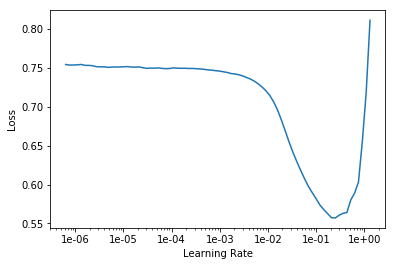

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.256086,0.220065,0.909612,05:33


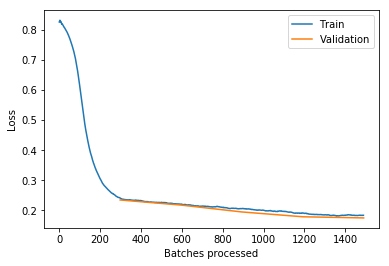

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('res_streetstyle_crop_loss_rn34_01')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


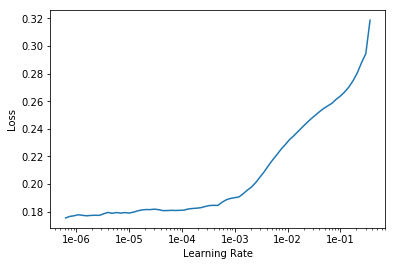

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.load('res_streetstyle_crop_loss_rn34_01')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.179338,0.173934,0.928405,04:10
1,0.176720,0.170779,0.929540,04:11
2,0.174169,0.168489,0.931263,04:11
3,0.169088,0.167725,0.931139,04:11
4,0.170037,0.167633,0.931314,04:11


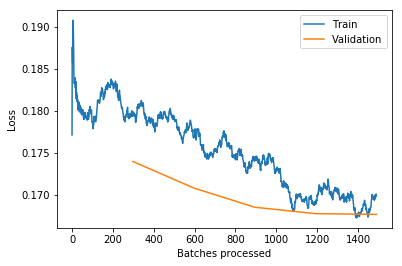

In [0]:
learn.recorder.plot_losses()

In [0]:
path = Path('/content/gdrive/My Drive/colab/model')
learn.save(path/'res_streetstyle_crop_loss_rn34_02')
#learn.save('res_streetstyle_crop_loss_rn34_02')

In [0]:
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
path = Path('/content/gdrive/My Drive/colab/model')
learn.load(path/'res_streetstyle_crop_loss_rn34_02')
learn.export(path/'export.pkl')
print('loaded')

loaded


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate])
learn.fit_one_cycle(1,1e-5)
model_path = '/content/gdrive/My Drive/colab/model/rn34_02.pth'
torch.save(learn.model.state_dict(), Path(model_path)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.833839,0.733241,0.520756,04:31


Prediction

In [0]:
import sys

sys.path.append('/content/gdrive/My Drive/colab')
from plotting_fns import *

In [0]:
def get_cat_preds(probs, cats, data_classes):
    assert len(probs.shape) == 2
    idxs = get_cat_idxs(cats, data_classes)    
    return cats[probs[:, idxs].argmax(dim = 1)]
  
probs, ys = learn.get_preds(DatasetType.Valid)
val_labs = labels[labels['valid']].copy()
len(val_labs.index)

2423

Attribute classification proved to be a very challenging task for certain attributes, but much more successful in classifying other attributes. We have computed the accuracy measurements a category by category basi.  Accuracy for clothing_category is as low as 0.679.

We also see measurements greatly varying from close to high accuracy for attributes like black or white, to low accuracy for attributes like grey.

In [0]:
for cat_col in categories:
    
    cats = get_cats(val_labs, cat_col)
    val_labs['pred_'+cat_col] = get_cat_preds(probs, cats, learn.data.classes)
    
for cat_col in categories:
    na_rows = val_labs[cat_col].isna()
    acc = (val_labs.loc[~na_rows, 'pred_'+cat_col] == val_labs.loc[~na_rows, cat_col]).mean()
    print(f'Accuracy for {cat_col} is {acc}')

Accuracy for clothing_pattern is 0.877521613832853
Accuracy for major_color is 0.7423376623376623
Accuracy for sleeve_length is 0.8188340807174888
Accuracy for neckline_shape is 0.8302900107411385
Accuracy for clothing_category is 0.6950431034482759
Accuracy for multiple_layers is 0.856463467358409


Confusion matrix, without normalization


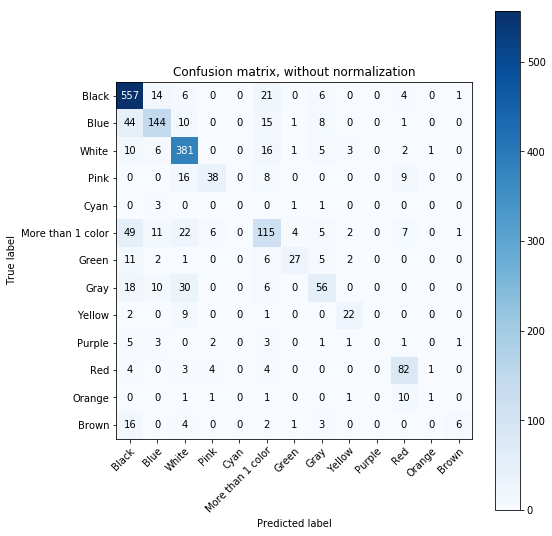

In [0]:
cat_col = 'major_color'
na_rows = val_labs[cat_col].isna()
plot_confusion_matrix(val_labs.loc[~na_rows, cat_col].apply(str), val_labs.loc[~na_rows, 'pred_'+cat_col].apply(str), figsize=(8, 8))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(losses)
len(losses)/data.c == len(val_labs.index)

True

Our second Model is ResNet50.

In [0]:
!ls -l data
#!rm -r streetstyle27k.tar
#!rm -r data/streetstyle27k

total 6696
drwxr-xr-x  5 root root    4096 May 15 16:15 all
drwxr-xr-x  5 root root    4096 May 15 20:07 cropped
drwxrwxr-x 18 1000 1000    4096 Aug 28  2017 streetstyle27k
-rw-r--r--  1 root root 6843031 Aug 28  2017 streetstyle27k.manifest


In [0]:
ARCH = models.resnet50
custom_loss = nn.BCEWithLogitsLoss(pos_weight=new_weights)
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.loss_func = custom_loss

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 97302851.27it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


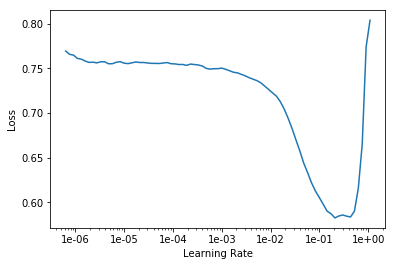

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.282419,0.268668,0.888743,05:25
1,0.285172,0.973600,0.880231,05:24
2,0.265886,1.385626,0.891416,05:25
3,0.245194,1.330089,0.892355,05:25
4,0.234163,1.675052,0.887360,05:26


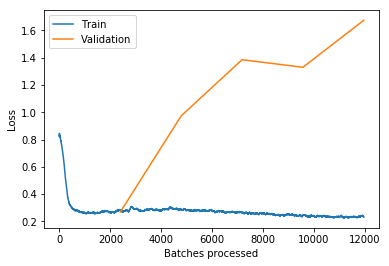

In [0]:
learn.save('res_streetstyle_crop_loss_rn50_01')
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


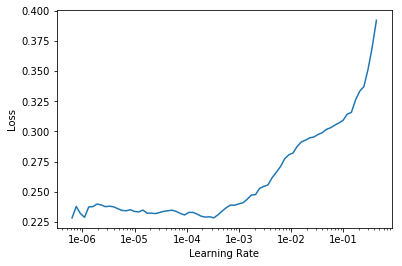

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.load('res_streetstyle_crop_loss_rn50_01')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.224413,1.855767,0.890580,07:01
1,0.231442,1.827104,0.897946,07:04
2,0.228297,1.785537,0.896213,07:05
3,0.229328,1.776508,0.892427,07:06
4,0.224351,2.243860,0.889951,07:06


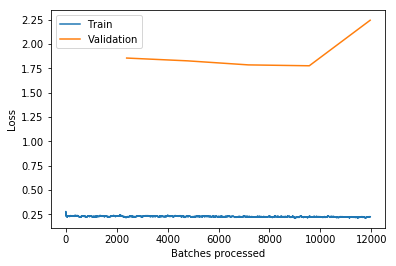

In [0]:
learn.recorder.plot_losses()

In [0]:
path = Path('/content/gdrive/My Drive/colab/model')
learn.save(path/'res_streetstyle_crop_loss_rn50_02')
#learn.save('res_streetstyle_crop_loss_rn50_02')
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.load(path/'res_streetstyle_crop_loss_rn50_02')
learn.export(path/'models/export.pkl')
print('loaded')

loaded


In [0]:
def get_cat_preds(probs, cats, data_classes):
    assert len(probs.shape) == 2
    idxs = get_cat_idxs(cats, data_classes)    
    return cats[probs[:, idxs].argmax(dim = 1)]
  
probs, ys = learn.get_preds(DatasetType.Valid)
val_labs = labels[labels['valid']].copy()

In [0]:
for cat_col in categories:
    
    cats = get_cats(val_labs, cat_col)
    val_labs['pred_'+cat_col] = get_cat_preds(probs, cats, learn.data.classes)
    
for cat_col in categories:
    na_rows = val_labs[cat_col].isna()
    acc = (val_labs.loc[~na_rows, 'pred_'+cat_col] == val_labs.loc[~na_rows, cat_col]).mean()
    print(f'Accuracy for {cat_col} is {acc}')

Accuracy for clothing_pattern is 0.7896253602305475
Accuracy for major_color is 0.6103896103896104
Accuracy for sleeve_length is 0.7206278026905829
Accuracy for neckline_shape is 0.7395273899033298
Accuracy for clothing_category is 0.5678879310344828
Accuracy for multiple_layers is 0.795071335927367


Confusion matrix, without normalization


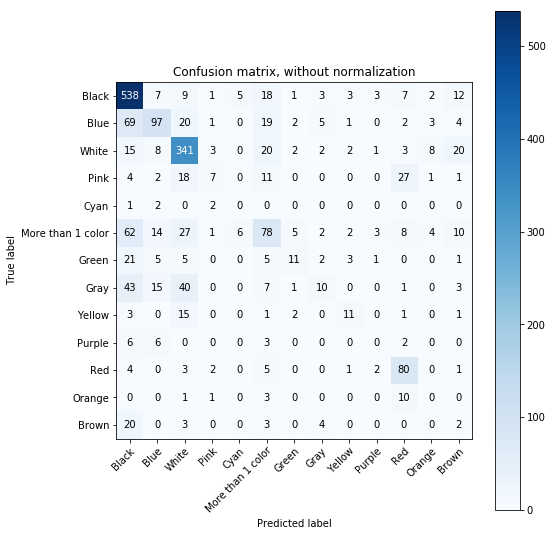

In [0]:
cat_col = 'major_color'
na_rows = val_labs[cat_col].isna()
plot_confusion_matrix(val_labs.loc[~na_rows, cat_col].apply(str), val_labs.loc[~na_rows, 'pred_'+cat_col].apply(str), figsize=(8, 8))data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAigAAAIYCAYAAABHdxcoAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3Xd4FOX2wPHvIREEaSItBOkl9JBC%0A6KAgRTpIEymCYr1e28+CFTsgKgqKvaIoeJXepEmHABEVC1xBIaAUAamShPP7Yye4hBASsjPJ5p7P%0A8+yT3Snved+Z2d03Z96ZFVXFGGOMMSY3yZfTFTDGGGOMScs6KMYYY4zJdayDYowxxphcxzooxhhj%0AjMl1rINijDHGmFzHOijGGGOMyXWsg2KMMcaYXMc6KMYYY4zJdayDYowxxphcxzooxhhjjMl1QnO6%0AAsYYY4zJmpCiFVWTj7saQ4/vnaeqHVwNkgHroBhjjDFBRpOPU6BmH1djnEiYUNLVAOdhHRRjjDEm%0A6AhI3h6lkbdbZ4wxxpigZBkUY4wxJtgIIJLTtXCVZVCMMcYYk+tYBsUYY4wJRjYGxRhjjDHGW5ZB%0AMcYYY4KRjUExxhhjjPGWZVCMMcaYoGP3QTHGGGOM8ZxlUIwxxphgZGNQjDHGGGO8ZRkUY4wxJtgI%0ANgbFGGOMMcZrlkExxhhjgo7YGBRjjDHGGK9ZBsUYY4wJRjYGxRhjjDHGW5ZBMcYYY4KRjUExxhhj%0AjPGWZVCMMcaYoGO/xWOMMcYY4znLoBhjjDHBRsjzY1Csg2KMMcYEIzvFY4wxxhjjLcugGGOMMUHH%0ABskaY4wxxnjOMijGGGNMMMqXtwfJWgbFGGOMMbmOZVCMMcaYYCPkijEoIrIdOAykAMmqGiMiJYBP%0AgUrAdqCPqh4QEQHGAVcDx4AhqrrhXGXnfOuMMcYYE8yuUNVIVY1xXj8ALFTV6sBC5zVAR6C68xgO%0AvJZRodZBMcYYY4KRiLuPC9cNeN95/j7Q3W/6B+qzGiguImHnKsQ6KMYYY4y5UArMF5H1IjLcmVZG%0AVXc7z38HyjjPw4EdfuvudKaly8agGGOMMUHHk/uglBSReL/Xb6jqG2mWaa6qiSJSGlggIj/6z1RV%0AFRG9kODWQTHGGGNMevb5jStJl6omOn/3iMgXQCPgDxEJU9XdzimcPc7iicDlfquXd6aly07xGGOM%0AMcEoh8egiMglIlIk9TnQDvgOmA4MdhYbDExznk8HBolPY+CQ36mgs1gGxRhjjDEXogzwhe/qYUKB%0Aj1V1roisAz4TkWHAr0AfZ/nZ+C4x3orvMuPrMyrcOijGGGNMMMrh+6Co6i9Ag3Sm7wfapDNdgdsy%0AW76d4jHGGGNMrmMZFGOMMSbYZP9eJbmeZVCMMcYYk+tYBsUYY4wJRrngt3jclLdbZ4wxxpigZBkU%0AY4wxJhjZGBRjjDHGGG9ZBsUYY4wJOp78Fk+OytutM8YYY0xQsgyKMcYYE4xsDIoxxhhjjLcsg2KM%0AMcYEG8HGoBhjjDHGeM0yKMYYY0zQsat4jDHGGGM8Zx0UY9IQkYIiMkNEDonIlGyUM0BE5geybjlF%0ARFqIyE+5JZ6IVBIRFRHLAqchIttFpK3zfISIvOVCjIki8kigyzVZlPqLxm49cph1UEzQEpFrRSRe%0ARI6IyG4RmSMizQNQ9DVAGeAyVe19oYWo6iRVbReA+rjK+aKvltEyqrpMVWt6Vae08fy/dN0mIu+J%0AyFNexHKbqj6jqjdkpwwRGSIiy9OUe7OqPpm92hmTMfvvwwQlEbkbeAC4GZgHnAQ6AN2A5RmsmhkV%0AgZ9VNTmb5eQJIhJq28Idtm1NttgYFGNyFxEpBjwB3Kaq/1HVo6qapKozVPX/nGUKiMhLIrLLebwk%0AIgWcea1FZKeI3CMie5zsy/XOvJHAo0BfJzMzTEQeF5GP/OKfcXrB+Q/zFxE5LCLbRGSA3/Tlfus1%0AFZF1zqmjdSLS1G/eEhF5UkRWOOXMF5GS52h/av3v86t/dxG5WkR+FpE/RWSE3/KNRGSViBx0lh0v%0AIvmdeV87i33jtLevX/n3i8jvwLup05x1qjoxopzX5URkr4i0zsS+e19E7nGehzvb8bY05eZLE+9D%0AoAIww6njfX5FDhCR30Rkn4g85Bcno/1/VkYgNYskIsOBAcB9TqwZ52iHisjNIrLF2a4TRHw5caf+%0AD4vIr87++cA5Zv2PnWEi8huwyG/a9SKyQ0QOOGXHisgmp/zxfrGrisgiEdnvtHuSiBQ/Rz1PH7vO%0Afj/i90gWkcedeQ+IyH+dY2+ziPRwptcCJgJNnHUOOtPPyDKJyI0istXZf9NFpFxmtpUxGbEOiglG%0ATYCLgS8yWOYhoDEQCTQAGgEP+80vCxQDwoFhwAQRuVRVHwOeAT5V1cKq+nZGFRGRS4CXgY6qWgRo%0ACiSks1wJYJaz7GXAC8AsEbnMb7FrgeuB0kB+4N4MQpfFtw3C8XWo3gSuA6KBFsAjIlLZWTYFuAso%0AiW/btQFuBVDVls4yDZz2fupXfgl82aTh/oFV9b/A/cBHIlIIeBd4X1WXZFDfVEuB1s7zVsAvQEu/%0A18tU9VSaeAOB34AuTh1H+81uDtR02vSo84UK59//6VLVN4BJwGgnVpcMFu8MxAL1gT5Ae2f6EOdx%0ABVAFKAyMT7NuK6CW3zoAcUB1oC/wktOGtkAdoI+ItHKWE+BZoJxTxuXA45lo2+1Omwrj224HgGnO%0A7P/iO26KASPx7dswVf0BX5ZylbPuWR0hEbnSqU8fIAz4FZicZrFzbSuTHTYGxZhc5zJg33lS4wOA%0AJ1R1j6ruxfehO9BvfpIzP0lVZwNH8H3RXYhTQF0RKaiqu1X1+3SW6QRsUdUPVTVZVT8BfgT8vwDf%0AVdWfVfU48Bm+L9dzSQKeVtUkfF8GJYFxqnrYib8Z3xczqrpeVVc7cbcDr+P7gjxfmx5T1b+d+pxB%0AVd8EtgJr8H0pPZR2mXNYCjQXkXz4OiajgWbOvFbO/KwYqarHVfUb4BucNnP+/R8Iz6nqQVX9DVjM%0AP/trAPCCqv6iqkeAB4F+cuaA3sedzJ//tn1SVU+o6nzgKPCJU/9EYBnQEEBVt6rqAmff7MXX2T3f%0A/jxNREoBXwL/UtWNTplTVHWXqp5yOqlb8HXqMmMA8I6qblDVv532NhGRSn7LnGtbGXNO1kExwWg/%0AUFIyvoKjHL7/5FL96kw7XUaaDs4xfP/pZomqHsX3H+/NwG4RmSUiEZmoT2qdwv1e/56F+uxX1RTn%0AeeqX3B9+84+nri8iNURkpoj8LiJ/4csQpXv6yM9eVT1xnmXeBOoCrzhfTOflZF+O4vuCagHMBHaJ%0ASE0urINyrm12vv0fCFmJHYpv4HWqHemUl3b/nWt/lhGRySKS6OzPjzj//sRZ9yJgKvCxqk72mz5I%0ARBKcUzAH8e3XTJVJmvY6nbL9XPixbTJDnPuguPnIYTlfA2OybhXwN9A9g2V24Ts9kaqCM+1CHAUK%0A+b0u6z9TVeep6lX4Mgk/4vviPl99UuuUeIF1yorX8NWruqoWBUbgO02QEc1opogUxnca4m3gcecU%0AVmYtxXelVH4nO7AUGAxcSjqnxzJTn3RktP/P2J8icsb+vIBYmYmdzJkdjuzEeMZZv56zP6/j/Psz%0A1SvAX/id7hKRiviO2dvxXblWHPjOr8zz1fWM9jqnPS/Dm2Pb5GHWQTFBR1UP4Rt3MUF8g0MLichF%0AItJRRFLHJ3wCPCwipcQ32PRRfP9pXogEoKWIVHAGOz6YOsP5b7ab86H8N75TRafSKWM2UEN8l0aH%0AikhfoDa+DILbiuD7UjriZHduSTP/D3xjJbJiHBDvXMI6C99ASuD0wMwlGay7FN+XYeoA3SXO6+V+%0AWaG0slrHjPb/N0AdEYkUkYs5e/zGhWyPtLHvEpHKTkcudUxToK7WKYLvODskIuHA/2VmJRG5CV+W%0AakCacT6X4OuE7HWWux5fBiXVH0B5cQZWp+MT4HpnexbA1941zulE4yYbg2JM7qOqY4G78f0nuBdf%0Ayvx2fOfWAZ4C4oFNwLfABmfahcRaAHzqlLWeMzsV+Zx67AL+xPcFkLYDgKruxzdQ8B586e/7gM6q%0Auu9C6pRF9+IbgHsY33/Kn6aZ/zjwvpPe73O+wkSkG75LulPbeTcQJc7VS/gGba7IoIil+L5kUzso%0Ay/FlNL4+5xq+QZgPO3XMaPBwqnPuf1X9Gd9VYF/hG2uR9rL0t4HaTqwvybp3gA/xtWcbcAL41wWU%0Acy4jgSjgEL7O4X8yuV5/fB2vXX5X8oxQ1c3AWHyZyT+Aepy5/xYB3wO/i8hZx6uqfgU8AnwO7Aaq%0AAv0upGEma0TE1UdOE9XsZjONMeYfIpIAtHE6ZcYYF+S7tJJefOWjrsY4/p9h61U1xtUgGbAbtRlj%0AAkpV7QoNY1wmkCuyHG6yUzzGGGOMyXUsg2KMMcYEGyHz124FKcugGGOMMSbXsQyKMcYYE3Ryx5U2%0AbrIOSh4joQVV8hfxJFZkrQqexMkJXr/tvbyWzusL9/J5uDHtmsTg5OX7zctj5Ldft7Nv37683Ytw%0AkXVQ8hjJX4QCNc97K4uAWLbqFU/ipPLykvjQEG/Pfp465V3bklLSu4+cewpcFOJZLLttQuB4eEgS%0A4mEvNtnD479l08z+nNGFyesZFBuDYowxxphcxzIoxhhjTBCyDIoxxhhjjMcsg2KMMcYEIcugGGOM%0AMcZ4zDIoxhhjTLCxO8kaY4wxxnjPOij/I36cNZJ1n41g9eQHWD7pPgAevbUTaz99kNWTH2DGq7cR%0AVqoYAEULX8zUl25izacPsH7qQwzs2jggdfj5p59oEtvw9COsZDEmvPxSQMpOz6vjX6ZRVH1iG9Zj%0AwivjXIsDcNMNQ6lQrjTRkXVdjZOqVo3KxEbVp3FsQ5o3iQ14+bfddAPVKobRJKbB6Wmbvkmgbaum%0ANI+LpnWzONavWxvwuF5uxxMnTtCiaRxx0ZFEN6jLkyMfyzPxvG6bl+/tHTt20L7tFTSsX5uoBnUY%0A/3Lg39u3DB9G5cvL0iiq/ulpDz14H1H1a9M4JpL+fXpy8ODBgMfNCnHuJOvmI6eJ3dgocEQkBfgW%0AX+ItBbhdVVeKSCVgpqpm+VNXRJYA96pqfGaWz1eotKZ3o7YfZ42k2YDR7D949PS0IpdczOGjJwC4%0AtX8rIqqEccfTk/m/oe0oVrggD788jZKXFuabLx6hUtsRJCWnnFHmvjUXfqO2lJQUqlcuz5Jlq6lQ%0AsWKm1snKsbr5++8YMvBalixfTf78+enR5WpeGv8qVatWy9T6Wb1R2/JlX3PJJYW5Yegg1id8l6V1%0AIes3aqtVozLLVq6jZMmSWY6VmRu1rVjua88tN17PqvhvAOjRpQO33v5vrmrfkflzZzPuxeeZNW/R%0AecvKyo3asrsds3KMqCpHjx6lcOHCJCUl0aZ1C55/4SUaxQWmQ56T8QIR60Jv1HYh7+2s3Kht9+7d%0A/L57Nw2jojh8+DBN46L5bOqX1KpdO1PrZ+ZGbcuXfU3hwoUZPmwIazdsAmDhgvm0uuJKQkNDeeSh%0ABwB48unnMiynZdNGbFgf78o3fehlVbRwhyfcKPq0Qx8PXK+qMa4GyYBlUALruKpGqmoD4EHg2Zyu%0AUEZSOycAhQoWOP3hrkDhSwoAcEnBAhw4dCzgd19csmghVapUzfQHWFb99OMPxMQ2olChQoSGhtK8%0ARUumf/mFK7EAmrdoSYkSJVwr32vNmrfk0jTtEREOHz4MwF9//UVYWLmAx/VyO4oIhQsXBiApKYmk%0ApCRw8b9GL+N53TZ/br+3w8LCaBgVBUCRIkWIiKjFrl2JAY3RvEVLLr30zOOwzVXtCA31DduMbRTH%0Arp07AxrzQuT1DIp1UNxTFDiQdqKIVBKRZSKywXk09Zt3v4h8KyLfiMhzadbLJyLvichTF1IZVWXG%0Aq7ezYtJ9DO3Z7PT0x2/rwpY5T9KvYwxPvjYLgImTlxJRuSy/zH+a+CkjuHfM1IDfQnzqlMlc06df%0AQMv0V6tOXVauWM7+/fs5duwY8+bNIXHnDtfieU0QunZqT7PGMbzz1huexHx29As8OuJ+6lSvxCMP%0A3sejTzztSVw3paSkEBfTkIrhZWjTpi2NGsXlmXhety2V2+9tf79u305CwkZiPWpbqg/ff5er2nfw%0ANOb/IuugBFZBEUkQkR+Bt4An01lmD3CVqkYBfYGXAUSkI9ANiHMyMKP91gkFJgFbVPXhC6lYm+tf%0ApOm1o+h++6vc1LcFzaKqAvD4hBlU7/gIk+fEc3PflgBc1bQWm37aSZV2DxHX71lefKA3RS65+ELC%0ApuvkyZPMmjmDHr16B6zMtCIianHXPf9H984d6NHlaurXb0BIiHe/CeO2rxYvY+Wa9XwxfTavT3yV%0A5cu+dj3m22++ztOjx/L9lu08M3os/7rlRtdjui0kJIQ18RvZsm0H8fHr+P67rJ9Wyq3xvG4bePPe%0ATnXkyBH69+nFmLEvUbRoUdfjpRrz3DOEhobSt/8Az2Kei2VQTFaknuKJADoAH8jZe/ki4E0R+RaY%0AAqSeOG0LvKuqxwBU9U+/dV4HvlPVdP9lFZHhIhIvIvGafDzdiu3aewiAvQeOMH3RJmLrVDpj/qez%0A19G9TSQAA7s2Ztoi37iDX3bsY3vifmpWKpOZ9mfK/LlziIyMokyZwJWZnsHXD2PZqnXMW7iE4sUv%0ApVr1Gq7G81K58HAASpcuTddu3Yl3YcBqWpMnfUDXbj0A6N7zGjbEr3M9pleKFy9Oy1atWTB/bp6L%0A52Usr97bSUlJ9O/Ti779B9C9R09XY/n76IP3mDNnFm+/91Gu+ALP66yD4hJVXQWUBEqlmXUX8AfQ%0AAIgB8meiuJXAFSKSbhpDVd9Q1RhVjZHQgmfNL3RxfgoXKnD6edsmEXz/311UrfBP1Tq3rs/P2/8A%0AYMfvB2jdqCYApUsUoUalMmxL3JeJambOlM8m07uv+yngvXv2ALDjt9+YPu0Levft73pMLxw9evT0%0AWJCjR4+y8KsF1K7j/lUvZcPKsXzZUgC+XrKIKlWrux7TTXv37j19Jcbx48dZtPAratSMyBPxvG5b%0AKi/e26rKzTcOo2ZELf59192uxvK3YP5cXnrheT6d+iWFChXyLG5G8noGxW7U5hIRiQBCgP2A/9Fc%0ADNipqqdEZLCzDMAC4FERmaSqx0SkhF8W5W2gJfCZiPRU1eSs1KX0ZUX49AVfOj40JIRP58SzYOUP%0AfPL8DVSvWJpTp5Tfdv/JHU9PBuC5N+fyxsjrWPfZCETgoXHTzrj6JzuOHj3K4oULeHnCxICUl5EB%0A/Xrz55/7ueiii3jhpVcoXry4a7EGXdefZUuXsG/fPqpWKs8jj45kyNBhrsTa88cf9Ovj+68xJTmZ%0APv360y7A58OHDR7A8q+Xsn//PmpXq8gDDz/GuAkTeeDeu0lOSebiAgUYN/61gMYEb7fj77t3c+Ow%0AIZxKSeHUqVP0vKY3V3fq7Eosr+N53Tbw7r29csUKPp70IXXr1iMu2pf1HfnUM3ToeHXAYlw/8FqW%0ALVvK/n37qFm1AiMefowXxozi77//plun9oBvoKwb7wHzD7vMOID8LjMG36XGI1R1lv9lxiJSHfgc%0A38Uyc4HbVLWws/4DwCDgJDBbVUf4X2YsIiOBGsAAVU33sppzXWbshuxcZnwhvDxWs3qZcXZl9TLj%0A7MjMZcaBlJXLjLPLPs8Cx8NDMkuXGWdXoK9IzIirlxmXrKLFOrk7UP3PD67N0cuMLYMSQKqa7iex%0Aqm4H6jrPtwD1/Wbf77fcc8BzadZt7ffc3bstGWOMMbmEdVCMMcaYIJQbxom4yQbJGmOMMSbXsQyK%0AMcYYE2RSf4snL7MMijHGGGNyHcugGGOMMUHIMijGGGOMMR6zDIoxxhgTjPJ2AsUyKMYYY4zJfSyD%0AksfUqVGeafPHeBJr257A3P4+s8pfdvbvDLkl1OMfPs7n4Z00NcWzUJ7z+kayXu43r4V42DQv7wDs%0A5V1rXSU2BsUYY4wxxnOWQTHGGGOCkGVQjDHGGGM8ZhkUY4wxJghZBsUYY4wxxmOWQTHGGGOCzP/C%0Ab/FYB8UYY4wJRnm7f2KneIwxxhiT+1gH5X/QX4cOctvQa7mqaSTtmjVkw7o1/PDdJq7p2JqOrWK5%0A8bpeHD78V0BiffT2q/Ro04jubWL58K0JANx7y2Cuad+Ua9o3pX2TOlzTvmlAYu3cuYMuHdrQOKoe%0ATaLrM3HCywAc+PNPenRuT3S9CHp0bs/BAwcCEs/fTTcMpUK50kRH1g142emZP28u9evUpE5ENcaM%0Afi7g5d9+0w1UrxhGk5gGp6d9u+kb2rVuRtPYSPr16sZffwXmGPG3Y8cO2re9gob1axPVoA7jXx4X%0A8Bj+atWoTGxUfRrHNqR5k1hXY+W1Y8Sfl/vtxIkTtGgaR1x0JNEN6vLkyMdci5UqJSWFxrFR9Oze%0AxfVYmebcqM3NR06zDorLRCRFRBJE5BsR2SAiTZ3plUTku5yo0xMP/R8tr7yKBSsTmLl4DdVq1OTB%0Au2/l/x55kjlL19Hu6q68OeHFbMfZ8uNmPv/4PT6euYSp81axdOFcftv2X55/7X2mzlvJ1Hkradux%0AK206dg1AqyA0JJSnnh3D6g3fMn/JCt56/TV+/GEzL44dRcvWV7L+2x9p2fpKXhw7KiDx/A0cPIRp%0AM+cGvNz0pKSkcOcdtzFtxhw2btrMlMmf8MPmzQGN0X/gIKZ+OeuMaf++9SYee/IZVq5LoHPX7rzy%0A4vMBjQkQGhrKc6PHsnHTZpYuX83rEycEvG1pzZm/iNXrNrJ81TpX4+S1Y8Sfl/utQIECzJm/kDXr%0AE1gdv5EF8+exds1qV2KlmvDKOCIiarkaw5zNOijuO66qkaraAHgQeDYnK3P4r0OsW72cPgOGAJA/%0Af36KFivOtv9upVGT5gA0a9WGeTOnZTvWL1t/ol7DGAoWLERoaCgxcc35au700/NVlXkzv+Dqbtdk%0AOxZA2bAwGjSMAqBIkSLUqBnB7l2JzJk5g/4DBgHQf8AgZs+YnlExF6R5i5aUKFEi4OWmZ93atVSt%0AWo3KVaqQP39+evftx8wZ2d9f/po1b8mladqzdevPNG3eEoDWbdoyY9oXAY0JEBYWRsOof/ZhREQt%0Adu1KDHicnJDXjhF/Xu43EaFw4cIAJCUlkZSUBC7+t79z507mzpnNkKHDXItxoSyDYgKpKHDW+QUR%0AGSIi4/1ezxSR1s7zdiKyysm+TBGRwtmpwI5ft1PispLcd8dNdLmyMQ/edQvHjh6les1aLJgzA4A5%0A0//D7sSd2QkDQPWatdiwdiUHD+zn+PFjLFs8j9/9PrTWr1nBZSVLU7FytWzHSuu3X7ez6ZsEomPj%0A2LPnD8qGhQFQpmxZ9uz5I+DxvLRrVyLly19++nV4eHkSE93/Eo+oVft0527af6aSuHOHq/F+3b6d%0AhISNxDaKcy2GIHTt1J5mjWN45603XIvjtZw6RsCb/ZaSkkJcTEMqhpehTZu2NHIx1n333MVTz44i%0AXz77uvSabXH3FXRO8fwIvAU8mdkVRaQk8DDQVlWjgHjg7uxUJjklme83JTBgyA3MWLSagoUuYeIr%0AzzNq3EQmvfsmXds25eiRw1yUP392wgBQpXoEQ2+9i+EDunPzdT2IqF2fkJB/foVvzrSpAcue+Dty%0A5AiD+vfh2dEvULRo0TPm5Zb/DILR+Ilv8fabr9G6aSOOHA7MMXIuR44coX+fXowZ+9JZ+zCQvlq8%0AjJVr1vPF9Nm8PvFVli/72rVY/wu82m8hISGsid/Ilm07iI9fx/ffuXO2fPasmZQqXYqoqGhXys8u%0Ay6CY7Eo9xRMBdAA+kMzv+cZAbWCFiCQAg4GKaRcSkeEiEi8i8X/u35dhgWFh4ZQtF05kdCMAOnbp%0AwfebEqhavSbvT5nB9K9W0qVnHypUqpyFJp5bz36D+Wz2Mt7/fB5FixU/nS1JTk7mq7nTad+1V0Di%0ApEpKSmLwtb3p3a8/Xbr3AKB06TL8vns3AL/v3k2pUqUDGtNr5cqFs9Mve5GYuJPw8HDX49aoGcF/%0AZsxlycq19OrTj8qVq7gSJykpif59etG3/wC69+jpSoxU5ZztVrp0abp26078urWuxvNKThwjXu63%0AVMWLF6dlq9YsmO/O2J7VK1cwa+YMIqpXZtB1/Vm6eBFDBw90JZY5m3VQPKSqq4CSQKk0s5I5c19c%0A7PwVYIHTwYlU1dqqetaJUFV9Q1VjVDWmxGUlM6xDqTJlCStXnl+2/gzAyq8XU61GLfbt3QPAqVOn%0AGP/CKK4dfMOFNPEs+/ftBWB34g6+mjudq7v3BmD1ssVUrlqDsmGB+9BUVf51y43UqFmL2+646/T0%0ADp0688mkDwD4ZNIHdOyci0biX4CY2Fi2bt3C9m3bOHnyJFM+nUynzoEZaJyRvXv+OUaeH/UM199w%0AU8BjqCo33ziMmhG1+Pdd2UoWntfRo0c5fPjw6ecLv1pA7TreXGHjNq+PES/32969ezl48CAAx48f%0AZ9HCr6hRM8KVWE88/Sxbt+3gxy3b+OCjT2h1xZW88/6HrsS6IOLyI4dZB8VDIhIBhAD708zaDkSK%0ASD4RuRxo5ExfDTQTkWrO+peISI3s1uOxZ8Zy1y3Xc3WrRmz+bhO33vl/zPhiCm0a1+eqppGUKRvG%0ANf0HZTcMAHcPH0C3K2O4/fo+PPTUCxQtVhyAOdOncnW33gGJkWr1qhV8+vFHfL10MS3iomkRF838%0AubO56577WbLoK6LrRbB08ULuuuf+gMYFGHRdf1q3aMLPP/1E1Urlee+dtwMeI1VoaCgvjhtPl07t%0AiaxXi169+1C7Tp2Axhg2eADtWjdn688/UadaRT587x0+nzKZmPq1aBRZh7JhYQwYNCSgMQFWrljB%0Ax5M+ZOniRcRFRxIXHcncObMDHgdgzx9/0PaKFsTFRNKqWRwdOl5Nu/YdXIkFee8Y8eflfvt99246%0AXHUljaIa0KJJI65s05arO3V2JZbJWaKqOV2HPE1EUoBvU18CI1R1lohUAmaqal3nlM9HQDTwA3Ap%0A8LiqLhGRK4FRQAGnjIdV9ZyXodSLjNJpC1a405g0jv2d4kmcVOUvK+hZrIsvCjn/QkHqRJK3+83L%0AbXnqlLefZ/ny5YJ/M/OAvPrUUxJKAAAgAElEQVQ91KxxLBvWx7tykOQvXU3L9n3BjaJP2zG+23pV%0AjXE1SAbsVvcuU9V0P51VdTtQ13muwIBzLLcIcPcOUsYYY0wuYx0UY4wxJsjklitt3GRjUIwxxhiT%0A61gGxRhjjAlClkExxhhjjPGYZVCMMcaYIGQZFGOMMcYYj1kGxRhjjAlGeTuBYhkUY4wxxlwYEQkR%0AkY0iMtN5XVlE1ojIVhH5VETyO9MLOK+3OvMrna9s66AYY4wxQSiX/Jrxv/HdAT3VKOBFVa0GHABS%0Afz9uGHDAmf6is1yG7BRPHhMako+SRQqcf8EACCnmbX6x06srPYs157amnsWCvD/YzSt26/nA8fL2%0A817+QkFSyinPYuXRO/ifJiLlgU7A08Ddzs+2XAlc6yzyPvA48BrQzXkOMBUYLyKiGRxo1kExxhhj%0Ago3kin9sXgLuA4o4ry8DDqpqsvN6J5D6k/XhwA4AVU0WkUPO8vvOVbid4jHGGGNMekqKSLzfY3jq%0ADBHpDOxR1fVuBbcMijHGGBNkBPAggbIvg18zbgZ0FZGrgYuBosA4oLiIhDpZlPJAorN8InA5sFNE%0AQoFiwP6MglsGxRhjjDFZoqoPqmp5Va0E9AMWqeoAYDFwjbPYYGCa83y68xpn/qKMxp+AZVCMMcaY%0AIJRrf834fmCyiDwFbATedqa/DXwoIluBP/F1ajJkHRRjjDHGXDBVXQIscZ7/AjRKZ5kTQO+slGsd%0AFGOMMSYI5c4ESuDYGBRjjDHG5DrWQfkfdNtNw6haoSyNo+ufnvbsUyOJqHI5zeOiaB4Xxfy5s12J%0APX7ci8RE1iW2YT2GDLyWEydOZKu8/CHCa/3q89aASN4d2JAhjS8/Y/6/WlVmzq2NT7+uH16UN65t%0AwMI7mtKq2mXZiu3vxIkTtGgaR1x0JNEN6vLkyMcCVnZ65s+bS/06NakTUY0xo58LaNk7d+6gS4c2%0ANI6qR5Po+kyc8DIAB/78kx6d2xNdL4Iendtz8MCBgMYF2LFjB+3bXkHD+rWJalCH8S+PC3iMnIjl%0AdbybbhhKhXKliY6s61oMf14f/4H+HPGXk8d/VuWSO8m6xjoo2SQiL4rInX6v54nIW36vx4rI3am/%0AU5DO+m+JSG3n+Qj3awzXDhzM59PO7oDc+q87Wb5mA8vXbKBdh6sDHndXYiKvTXiFZavWsW7jt6Sk%0ApDD1s8nZKvNkinL3599xw6QEbpiUQKNKl1K7bGEAapYuTJGLzzyLuefw3zw3fwtf/bg3W3HTKlCg%0AAHPmL2TN+gRWx29kwfx5rF2zOqAxUqWkpHDnHbcxbcYcNm7azJTJn/DD5s0BKz80JJSnnh3D6g3f%0AMn/JCt56/TV+/GEzL44dRcvWV7L+2x9p2fpKXhx73jtVZz12aCjPjR7Lxk2bWbp8Na9PnBDQtuVU%0ALK/jDRw8hGkz57pSdnq8PP7d+Bzxl5PHvzmTdVCybwXQFEBE8gElgTp+85sC+c+1sqreoKqpn1Ke%0AdFCaNW/JpSVKeBHqLMkpyRw/fpzk5GSOHztGWFi5bJd5PMl36+rQfEJoPkGBfAI3t6jExGXbz1j2%0A97/+5pd9x1ACew9qEaFwYV/HKCkpiaSkJNdOEK9bu5aqVatRuUoV8ufPT+++/Zg5Y9r5V8yksmFh%0ANGgYBUCRIkWoUTOC3bsSmTNzBv0HDAKg/4BBzJ4xPWAxU4WFhdEw6p/YERG12LUr8Txr5f5YXsdr%0A3qIlJTx8j3t5/IM7nyOpcvL4zxLxbWI3HznNOijZtxJo4jyvA3wHHBaRS0WkAFAL2AAUFpGpIvKj%0AiExyfrMAEVkiIjEi8hxQUEQSRGSSM+86EVnrTHtdRELcbMibEyfQNDaS224axgEX0pflwsO54857%0AqFWtIlUrlqNosWK0uapdtsvNJ/DWgAZ8ObwR8b8d5Iffj9CjQRgrfvmTP48lBaDmmZOSkkJcTEMq%0AhpehTZu2NGoU50qcXbsSKV/+n1NZ4eHlSUx054vut1+3s+mbBKJj49iz5w/KhoUBUKZsWfbs+cOV%0AmKl+3b6dhISNxLq0HXMqVk7E84JXx79bnyPpycnj31gHJdtUdReQLCIV8GVLVgFr8HVaYoBvgZNA%0AQ+BOoDZQBd9d+PzLeQA4rqqRqjpARGoBfYFmqhoJpAAD3GrHsBtvJmHzFpav2UCZsmE8/MC9AY9x%0A4MABZs2cznc//cLW7YkcO3qUyR9/lO1yTyncMOkber+9jlplilA/vCitq5fki4RdAah15oWEhLAm%0AfiNbtu0gPn4d33/3nafxA+3IkSMM6t+HZ0e/QNGiRc+Y5/Y56iNHjtC/Ty/GjH3prNjBHCsn4nnF%0Aq+Pfrc+RtHLy+M8MwffjmG4+cpp1UAJjJb7OSWoHZZXf6xXOMmtVdaeqngISgErnKbMNEA2sE5EE%0A53WV9BYUkeGpv5Wwf++Fja0oXaYMISEh5MuXj8FDb2B9/LoLKicjixd9RaVKlShVqhQXXXQRXbv3%0AYPWqwP1C8ZG/U9i48xANyxcjvPjFTLo+mslDoylwUT4mDYkKWJzzKV68OC1btWbBfHfGAJQrF87O%0AnTtOv05M3El4eHgGa2RdUlISg6/tTe9+/enSvQcApUuX4ffduwH4ffduSpUqHdCY/rH79+lF3/4D%0A6N6jpysxciJWTsTLCW4f/25/jkDOHv/mH9ZBCYzUcSj18J3iWY0vg9IUX+cF4G+/5VM4/z1oBHjf%0AyahEqmpNVX08vQVV9Q1VjVHVmMtKlbqgBqS+8QBmTvuSWrXrZLD0hbn88gqsXbOGY8eOoaosWbyI%0AmhG1slVmsYKhFC7gO/OVPyQfMRWK8fOeI/R8cx393llPv3fW83fSKQa8tyEQTTinvXv3cvDgQQCO%0AHz/OooVfUaNmhCuxYmJj2bp1C9u3bePkyZNM+XQynTp3DVj5qsq/brmRGjVrcdsdd52e3qFTZz6Z%0A9AEAn0z6gI6duwQspn/sm28cRs2IWvz7rrsDXn5OxcqJeF7y8vh343PEX04e/1mV18eg2I3aAmMl%0AcC/wi6qmAH+KSHF8Y1JuBDJ7rV+SiFykqknAQmCaiLyoqntEpARQRFV/zW5lhw66luXLlrJ/3z5q%0AVa3Ag488xvKvl/Ltpm8QESpUrMhLr0zMbpizxDaKo3vPXjSLiyY0NJQGkQ0ZesPw86+Ygcsuyc+D%0A7aqTT4R8Aou37GfVtnOPn6lZpjBPdY6g8MWhNKlcgiFNKnD9hxuzVQfwdfBuHDaEUykpnDp1ip7X%0A9ObqTp2zXW56QkNDeXHceLp0ak9KSgqDhwyldp3AdShXr1rBpx9/RO269WgRFw3AIyOf5K577uf6%0Agf346P13ubxCBd79MHBXTqRauWIFH0/6kLp16xEXHQnAyKeeoUPHwF9V5mUsr+MNuq4/y5YuYd++%0AfVStVJ5HHh3JkKHDAh4nlZfHvxufI/5y8vg3Z5Lz/FaPyQRn8OoB4GVVfdiZ9h7QRFVrikhr4F5V%0A7ezMGw/Eq+p7IrLEmRcvIqOArsAGZxxKX+BBfJmuJOA2Vc3w2r2G0TG6dMVaV9qZVojH5yg7vRrY%0ANG5G5tzW1LNYgKfns08kpXgWC+Dii1wd221c4uV3wykPv4aSUk55FuuKZnFs3BDvypu7YFgNrTps%0AghtFn/b90+3WZ/Brxq6zDEoAOFmTommmDfF7vgTndwqc17f7PW/t9/x+fD+0lPr6U+DTwNfYGGOM%0Ayd2sg2KMMcYEm1wyTsRN1kExxhhjgozg7anhnGBX8RhjjDEm17EMijHGGBN0cv5mcW6zDIoxxhhj%0Ach3LoBhjjDFBKI8nUCyDYowxxpjcxzIoxhhjTBDK62NQrIOSxwhwUYg3B63Xb45pNzX2LJaXd7YE%0A8GiXARCaC36l1OR+x096d8fhQgW8+yoKyefdnY3trZY91kExxhhjgs3/wI3abAyKMcYYY3Idy6AY%0AY4wxQcbuJGuMMcYYkwMsg2KMMcYEoTyeQLEMijHGGGNyH8ugGGOMMUHIxqAYY4wxxnjMOiiGlJQU%0AGsdG0bN7F1fj7Nixg/Ztr6Bh/dpENajD+JfHBbT82266gWoVw2gS0+D0tE3fJNC2VVOax0XTulkc%0A69etDWjMVD//9BNNYhuefoSVLMaEl19yJRbA/HlzqV+nJnUiqjFm9HMBL/+W4cOofHlZGkXVPz3t%0Ai8+nENuwHkULhrJhfXzAY6Zyu205FcvreG7GSty5g24d29Ikuj5NYxrw+oSXARg26FpaNYmmVZNo%0AImtXo1WT6IDGBbjphqFUKFea6Mi6AS87N8TLChF3HznNOigeEJEUEUkQke9EZIqIFHKmr8zEuttF%0ApKSb9ZvwyjgiImq5GQKA0NBQnhs9lo2bNrN0+WpenziBHzZvDlj51w4cxNQvZ50x7bGHH+D+EY+w%0AfM16RjzyGI8+/EDA4vmrUbMmq9ZtZNW6jSxfHU/BQoXo0q2HK7FSUlK4847bmDZjDhs3bWbK5E8C%0Auh0BBgwczBfTZ58xrVadukz6dCrNmrcMaCx/XrQtJ2J5Hc/tWCGhoTzx7GhWrd/EvMXLefvNifz4%0Aw2be/uBjlq5az9JV6+nSrQeduwb+PTBw8BCmzZwb8HJzSzzzD+ugeOO4qkaqal3gJHAzgKo2zdlq%0Awc6dO5k7ZzZDhg5zPVZYWBgNo6IAKFKkCBERtdi1KzFg5Tdr3pJLS5Q4Y5qIcPjwYQD++usvwsLK%0ABSzeuSxZtJAqVapSoWJFV8pft3YtVatWo3KVKuTPn5/effsxc8a0gMZo3qIll1565raMiKhFjRo1%0AAxonLS/alhOxvI7ndqyyZcNoEPnPe7l6zQh27951er6q8uV/ptKzd9+AxUzVvEVLSqR5n7vJ63iZ%0AJr7PNzcfOc06KN5bBlQDEJEjzt/WIrJERKaKyI8iMknSHB0iUlBE5ojIjYGszH333MVTz44iXz5v%0AD4Vft28nIWEjsY3iXI3z7OgXeHTE/dSpXolHHryPR5942tV4AFOnTOaaPv1cK3/XrkTKl7/89Ovw%0A8PIkJgauo5eTvGyb19sxr7btt1+38+03CUTHNDo9bdWK5ZQqXZqq1aq7EtP8b7AOiodEJBToCHyb%0AzuyGwJ1AbaAK0MxvXmFgBvCJqr4ZqPrMnjWTUqVLERUV+PPEGTly5Aj9+/RizNiXKFq0qKux3n7z%0AdZ4ePZbvt2znmdFj+dctAe3fneXkyZPMmjmDHr16uxrHmNzgyJEjDBnQh6dHjT3jvfz5lMn06u1e%0AJ92k3knWxqCY7CsoIglAPPAb8HY6y6xV1Z2qegpIACr5zZsGvKuqH6RXuIgMF5F4EYnft29vpiu1%0AeuUKZs2cQUT1ygy6rj9LFy9i6OCBmV7/QiQlJdG/Ty/69h9A9x49XY0FMHnSB3R1xoJ073kNG+LX%0AuRpv/tw5REZGUaZMGddilCsXzs6dO06/TkzcSXh4uGvxvORl27zejnmtbUlJSQwZ0Idr+vY/Y7xV%0AcnIys6Z/SXfrpJtssg6KN1LHoESq6r9U9WQ6y/zt9zyFM+9RswLokPa0TypVfUNVY1Q1pmTJUpmu%0A1BNPP8vWbTv4ccs2PvjoE1pdcSXvvP9hptfPKlXl5huHUTOiFv++627X4vgrG1aO5cuWAvD1kkVU%0AqepuynnKZ5Pp3dfd/xxjYmPZunUL27dt4+TJk0z5dDKdOnd1NaZXvGyb19sxL7VNVbnj1hupUTOC%0AW/911xnzli5eSPUaNQkPLx+weCY97o4/sTEoJrMeBQ4AE3K6ItmxcsUKPp70IUsXLyIuOpK46Ejm%0Azpl9/hUzadjgAbRr3ZwtP/9E7WoV+eC9dxg3YSIPP3AfzeKieOKxhxk3/rWAxUvr6NGjLF64gK7d%0A3c0MhYaG8uK48XTp1J7IerXo1bsPtevUCWiM6wdeS5vWzdjy80/UrFqB9999m+nTvqBm1QqsXbOK%0Aa3p0oXvnDgGNCd60LSdieR3P7VhrVq3gs08msWzp4tOXFS+YNweA/0z91JXBsakGXdef1i2a8PNP%0AP1G1Unneeye9hHTwxjP/EFXN6TrkeSJyRFULn2u6iLQG7lXVzs708UC8qr4nItuBGGA/8A6wV1Xv%0AO1esqOgYXbHa3dMYqbzuYf+dlOJZrNAQb/vuIfm825bJKac8iwXeb0sTGMf+TvYsVqECefOm5s3i%0AYli/Pt6VN3fh8hFa/4433Cj6tFX3t1qvqjGuBslA3jwqcpn0Oif+01V1CbDEb/rtfs8r+a1yvSsV%0ANMYYY3IZ66AYY4wxQSg3jBNxk+VejTHGGJPrWAbFGGOMCTa55F4lbrIMijHGGGNyHcugGGOMMUHG%0AdyfZvJ1CsQyKMcYYY3Idy6AYY4wxQcgyKMYYY4wxHrMMijHGGBOE8ngCxTooeU1eHjhV4KKQnK5C%0AnmC3njeZkVdvP2+Chx2BxhhjTBDKq/+MprJ/pYwxxhiT61gGxRhjjAk2/wN3krUOijHGGBNkBLFT%0APMYYY4wxXrMMijHGGBOE8ngCxTIoxhhjjMl9LINijDHGBKF8eTyFYhmU/3E33TCUCuVKEx1Z1/VY%0AO3bsoH3bK2hYvzZRDeow/uVxrsabP28u9evUpE5ENcaMfs7VWHm5bV7G8jqetS34Ynkdz+u2mX9Y%0AB8UFIlJWRCaLyH9FZL2IzBaRGjldr/QMHDyEaTPnehIrNDSU50aPZeOmzSxdvprXJ07gh82bXYmV%0AkpLCnXfcxrQZc9i4aTNTJn/iWizIu23zejta2yxWborndduySsTdR06zDkqAie+6ry+AJapaVVWj%0AgQeBMjlbs/Q1b9GSEiVKeBIrLCyMhlFRABQpUoSIiFrs2pXoSqx1a9dStWo1KlepQv78+endtx8z%0AZ0xzJRbk3bZ5vR2tbRYrN8Xzum3mTNZBCbwrgCRVnZg6QVW/AW4Uke6p00Rkkoh0E5FKIrJMRDY4%0Aj6bO/NYiskREporIj87yuaBPGxi/bt9OQsJGYhvFuVL+rl2JlC9/+enX4eHlSUx0p8OQVl5qm9fb%0A0dpmsXJTvJz8HDkfX5ZDXH3kNOugBF5dYH06098GhgCISDGgKTAL2ANcpapRQF/gZb91GgJ3ArWB%0AKkAz12rtoSNHjtC/Ty/GjH2JokWL5nR1Aiovt80YY7xkHRSPqOpSoLqIlAL6A5+rajJwEfCmiHwL%0ATMHXGUm1VlV3quopIAGolF7ZIjJcROJFJH7vvr2utiO7kpKS6N+nF337D6B7j56uxSlXLpydO3ec%0Afp2YuJPw8HDX4kHebJvX29HaZrFyU7yc+BzJinzi7iOnWQcl8L4Hos8x7wPgOuB64B1n2l3AH0AD%0AIAbI77f8337PUzjHZeGq+oaqxqhqTKmSpbJRdXepKjffOIyaEbX49113uxorJjaWrVu3sH3bNk6e%0APMmUTyfTqXNX1+Ll1bZ5vR2tbRYrN8Xzum3mTHYflMBbBDwjIsNV9Q0AEakPFAPeA9YCv6tq6lDw%0AYsBOVT0lIoOBEC8rO+i6/ixbuoR9+/ZRtVJ5Hnl0JEOGDnMl1soVK/h40ofUrVuPuOhIAEY+9Qwd%0AOl4d8FihoaG8OG48XTq1JyUlhcFDhlK7Tp2Ax0mVV9vm9Xa0tlms3BTP67ZlVW4YJ+ImUdWcrkOe%0AIyLlgJfwZVJOANuBO1V1i4jMBb5MHUQrItWBzwEF5gK3qWphEWkN3KuqnZ3lxgPxqvpeRrGjo2N0%0AxZp4V9pljDEm85rFxbB+fbwrvYhiFWtpswffd6Po0+bcErdeVWNcDZIBy6C4QFV3AX3STheRQkB1%0A4BO/ZbcA9f0Wu9+ZvgRY4rfc7e7U1hhjTDDK4wkUG4PiFRFpC/wAvKKqh3K6PsYYY0xuZhkUj6jq%0AV0DFnK6HMcaY4CeAkLdTKJZBMcYYY0yuYxkUY4wxJgjlhnuVuMkyKMYYY4zJdSyDYowxxgSbXPJ7%0AOW6yDIoxxhhjch3LoBhjjDFBKI8nUKyDktckpSh/HDrhSawSl+Q//0IBlJRyyrNYhQp4+9Y4dcq7%0AOzonHjjuWSyA8EsLehYrXx4eNej1Xb89PCQ9HeyZ4mHD7D7t2WMdFGOMMSbICJAvj6dQbAyKMcYY%0AY3Idy6AYY4wxQSiPJ1Asg2KMMcaY3McyKMYYY0wQsvugGGOMMcZ4zDIoxhhjTJARsTEoxhhjjDGe%0Asw7K/6BDhw5yy/X9ubJxA9o0iWT9utU889iDXNm4AR1axjJ8UB8OHToYkFi33jSMKhXKEhdd/6x5%0Ar7z0AkULhrB/376AxErcuYNuHdvSJLo+TWMa8PqElwEYNuhaWjWJplWTaCJrV6NVk+iAxPN30w1D%0AqVCuNNGRdQNednoOHjzIgH69aVivFlH1a7Nm9aqAlf3L1p/p2qbx6UfDamV5743xbP7uG3pf3Zqu%0AbRrTs11zvtkQH7CY/mrVqExsVH0axzakeZNYV2IA7Nixg/Ztr6Bh/dpENajD+JfHuRbL63gnTpyg%0ARdM44qIjiW5QlydHPuZaLIDx414kJrIusQ3rMWTgtZw44f7NIlNSUmgcG0XP7l0CXvYtw4dR+fKy%0ANIr653Przz//pOvV7YisU5OuV7fjwIEDAY+bVflEXH1kREQuFpG1IvKNiHwvIiOd6ZVFZI2IbBWR%0AT0UkvzO9gPN6qzO/0nnbF4BtdK7Kq4h85Pc6VET2ishMF2IVF5Fb/V63diOOU/ZcETkYqPJFpJKI%0AfBeIsjJr5Ih7aXVlOxat/oY5S9dSrUYEzVu3Yf7y9cz9eh2Vq1bn1ZfGBCTWgIGD+c+02WdN37lj%0ABwsXzufyyysEJA5ASGgoTzw7mlXrNzFv8XLefnMiP/6wmbc/+Jilq9azdNV6unTrQeeuPQIWM9XA%0AwUOYNnNuwMs9l/+7506uateejd/+wOr4BGpG1ApY2VWq1WD6wtVMX7iaL+avoGDBglzVsStjnnyY%0A2+95kOkLV3PHfQ8z5smHAxYzrTnzF7F63UaWr1rnWozQ0FCeGz2WjZs2s3T5al6fOIEfNm/OE/EK%0AFCjAnPkLWbM+gdXxG1kwfx5r16x2JdauxERem/AKy1atY93Gb0lJSWHqZ5NdieVvwivjiAjgce9v%0AwMDBfDH9zM+tF54fRasr2pDw/U+0uqINLzw/ypXYQeRv4EpVbQBEAh1EpDEwCnhRVasBB4BhzvLD%0AgAPO9Bed5TLkZgblKFBXRFLvc30VkJiVAkQks2NkigO3nnepwBgDDPQo1lmysE3S9ddfh1i7ajl9%0ArxsCQP78+SlWrDgtr2hLaKiv6IYxjfh9V5Z21Tk1a96SS0uUOGv6g/fdzZNPjwroKPSyZcNoEBkF%0AQJEiRaheM4Ldu3ednq+qfPmfqfTs3TdgMVM1b9GSEum00w2HDh1ixbKvGXy9732fP39+ihcv7kqs%0AVcsWU6FSFcIvr4CIcOTwYQCOHP6L0mXLuhLTK2FhYTSM+ud4iYioxa4AHfc5HU9EKFy4MABJSUkk%0AJSW5OmAhOSWZ48ePk5yczPFjxwgLK+daLICdO3cyd85shgwddv6FL0DzFi259NIz38+zZkxnwHWD%0AABhw3SBmTp/mSuysEJcfGVGfI87Li5yHAlcCU53p7wPdnefdnNc489vIeb4A3D7FMxvo5DzvD3yS%0AOkNESojIlyKySURWi0h9Z/rjIvKhiKwAPhSREBEZIyLrnGVvSifOc0BVEUkQkdR//QuLyFQR+VFE%0AJqVuCBF51CnrOxF5w2/6EhEZ5aSsfhaRFuk1SFUXAoczarSIVBORr5zU1wYRqSo+Y5y434rIWd+S%0ATsrsXWf+RhG5wpk+RESmi8giYGFGsc9nx6/bueyyktz7r+FcfUVj7v/3LRw7evSMZaZM+oDWbdpn%0AJ0yGZs2YRli5cOrVb+BajN9+3c633yQQHdPo9LRVK5ZTqnRpqlar7lpcL2zfvo2SpUpx041DadIo%0AiltvvoGjafZhoMz6ciqduvcGYMQToxn95EO0jKrBcyNHcM+IJ1yJKQhdO7WnWeMY3nnrDVdipPXr%0A9u0kJGwktlFcnomXkpJCXExDKoaXoU2btjRyKVa58HDuuPMealWrSNWK5SharBhtrmrnSqxU991z%0AF089O4p8+bwbpbB3zx+UDQsDoEzZsuzd84dnsXMr5/s5AdgDLAD+CxxU1WRnkZ1AuPM8HNgB4Mw/%0ABFyWUflu793JQD8RuRioD6zxmzcS2Kiq9YERwAd+82oDbVW1P7600CFVjQVigRtFpHKaOA8A/1XV%0ASFX9P2daQ+BOp6wqQDNn+nhVjVXVukBBoLNfOaGq2shZLzsnbScBE5zUV1NgN9ATXxqsAdAWGCMi%0AYWnWuw1fx7Qevg7d+862A4gCrlHVVtmoFynJyXy3KYHrrr+R2YtXU/CSQrz28vOn549/YRQhoSF0%0A790vO2HO6dixYzw/+jkeenSkK+UDHDlyhCED+vD0qLEULVr09PTPp0yml0vt8lJKcjIJGzdw4/Cb%0AWbV2A4UKXcLYMc8FPM7JkydZOH82HZ1TYp+8/xYjRo7i6w0/M2LkKEbcfUvAYwJ8tXgZK9es54vp%0As3l94qssX/a1K3FSHTlyhP59ejFm7EtnHC/BHi8kJIQ18RvZsm0H8fHr+P47d84kHzhwgFkzp/Pd%0AT7+wdXsix44eZfLHH51/xQs0e9ZMSpUuRVRU4MeSZZaI5Ip7kKTWw60HUFJE4v0ew/3jq2qKqkYC%0A5YFGQEQg2+dqB0VVNwGV8H3Zph2I0Bz40FluEXCZiKS+W6eraupPrrYDBjm9tDX4elyZ+Rd4raru%0AVNVTQIJTD4ArnAE63+JLRdXxW+c/zt/1fstniYgUAcJV9QunbSdU9Ri+9n7i7NA/gKX4Olz+mgMf%0AOev9CPwK1HDmLVDVP88Rc3jqAfTn/r0Z1q9suXDKlgunYbQvs3B1lx58900CAFM++ZCF82czbuJ7%0Arr35tv3yX379dRvNGjWkbs0qJCbupEWTGP74/feAlJ+UlMSQAX24pm9/unT7Z6xJcnIys6Z/Sfde%0AvQMSJyeVCy9PePnyp1pNpvkAACAASURBVP/77tHzGhI2bgx4nK8XzadOvQaULFUGgC8+m0S7Tt0A%0A6Ni1J5s2rg94TPD9Rw5QunRpunbrTvy6ta7EAd/x0r9PL/r2H0D3Hj1di5NT8QCKFy9Oy1atWTDf%0AnTFSixd9RaVKlfh/9u47Poo6/+P460MiqAeIHD0BpUgCoYQUAtKLgDRBpFdBsHA2zjuv/pSznr3e%0AoZ4NxYZ3SlGaARSQlgAi4iF4oBCCgoonCEdYPr8/ZoJLhCTAzGyyfJ489sHu7Oy8v9/Z2c13v/Od%0AmapVq3LWWWfRt19/Viz/0JcsgBUfLuOd2bNIvKguo0YM5f1FCxk72v+97lWrVWdXbi4Au3JzqVK1%0Amu+ZJcAeVU0Lux23S1NV9wKLgNZApbChCPH8NLQjB6gNR4cqnAd8U1h4EP1jM4EHCNu9Uwzh/dUC%0AXO/2jiSral1VnV+MZfwv7H4IiHV7I/6G0xPRFHgGOPs4rwlR8s4Rc8I+fFV9On8DqvzLqoUupFr1%0AGtSKi+fzzZ8BsOyDxVyUkMjizPk89fhD/OPlNznn3HO9LXmYpCZN+c+Xu9iw6T9s2PQf4uLiWbI8%0Ai+oejGdQVW64bjwNExK57vqbj3nu/UWZXNQwgbi4+NPOibQaNWoQH1+bzzZtAmDxokwSG3k/WHD2%0AW9Pp3e+nBl21GjVZ9eESAJYvXcyF9ep7nrl//35+cMe57N+/n8z3FtA4yZ8jo1SVa8aPIyGxETfe%0APMmXjEjl7d69m717nSPxDhw4wMLM92iY4OmP26Nq167DqpUr+fHHH1FVFi9a6Omg7YL+ctc9bNm6%0AnX9v3srUl1+lQ6fOPPfiS77l5evZuw/TXnY6+qe9PJVeffr6nlkY52rG/t4KzRepKiKV3Pvn4Iwz%0A/RSnoXKFO9toIH+wzkz3Me7zC1VVC8sIooHyHDBZVT8uMH0JMByco25wWmr/Pc7r5wHXishZ7rwN%0AReQXBeb5AahQjLLkN0b2iEh5flqJnlHVH4AdItIPjh5adS5OfQe7++yqAu2Bgj8Nw9dJQ6AOsMnr%0AMt5+z0PcdM2V9GifzsYNHzHx5t9y2+9uZv++HxhxRW8u7ZjBH359vSdZV44aRteObdj82SYS69dh%0A6gvPerLc41m5fBlvvDqNJe8vOnpY8YJ5cwD415uv+zI4Nt+oEUPp2K41n23aRP0L43nhOf/qCfDA%0Aw48xdswIWqY2Z/1HH/GbW//g6fJ/3L+fDz9YeLTHBODOB57g3sm/p0/nDB66+3buuP8JTzMBvv7q%0AK7p2akdGWjId2mTQ49KedOvew/McgA+XLeOVaS/x/qKFZKQmk5GazNw5Pz/irDTm7crNpcclnWmZ%0A0px2rVvSuUtXevbqXfQLT0F6ywz6XT6ANhmptExpxpEjRxh71YSiX1iCXTlyGF3c762E+nV48fln%0AmXTLrSzKfI/kpAQWL8xk0i23RrqYkVYTWCQi64HVOL38s4FbgUkisgVnj0f+l+GzOHtKtgCTcIZm%0AFEpO1IAJ291yXCdoTIS/fp+qli8wrSNwi6r2FpHKOI2XesCPwARVXS8itwP7VPUB9zVlgDuBPjiN%0Axt1AP1X9vsCyX8EZ5zIHeCc/x33uCSBLVV8QkTtxdjntAj4DvlDV20VksfuaLBGp4s5/4XHqtQRn%0AP1t5nO6pcao6r8A8FwFPAVWAPGAgsBW4D7gUZ6Tznar6ujjHgs9W1SZuD8/fgTTgMDBJVReJyBgg%0ATVV/Vdg6B2iWnKqzMpcVNZsnKv+ibCA5+fJCRwLLOrdcsB1oR44U+kPCUznfHSh6Jg/FnX9O0TN5%0ApExRP/tKsSJ+bHouwE2yyF/rXgoFWLH2F7dkTXaWL7X7Zb0kvfQvr/ix6KOmjUzOVtU0X0MKUVgD%0AZTvOH9LwlZv/WFXVuxNYGM9YA8Ub1kDxjjVQvGENFG9EUwOl5x3+NlBeHhHZBsoJv4VVtXaQBTHG%0AGGOMyVesn4kiMgSop6p3i0g8UF1V/RnCb4wxxpgilYRDnf1U5CBZd/xGJ346e+qPwBQ/C2WMMcaY%0AM1txelAuVtUUEVkLoKrfinvxH2OMMcYEL/8w42hWnMOM89wjaRRARH4JBDda0RhjjDFnnOL0oDwJ%0A/BOoKs7llAfhnKbeGGOMMRES7WNQimygqOpUEcnGuX4MwEBV9eeiDsYYY4wxFP907jE4JxxTgjn7%0ArDHGGGMKEd39J8U7iuePONfRqYVz4Z9XROT3fhfMGGOMMWeu4vSgjAJauFfkRUTuAtYC9/hZMHNq%0AYsoI5517VmBZQYopExNoXpCCPANqkGd2BTgS4BlQywT8mzLIs7sGPd4gJkp/nscGWDE/k0SgTJSP%0AQSnO7ppcjm3IxLrTjDHGGGN8ccIeFBF5GGfMybfAJyIyz33cDefKhcYYY4yJkCjvQCl0F0/+kTqf%0A4FwdON8K/4pjjDHGGFP4xQKfDbIgxhhjjCm+M/48KCJSH7gLaAycnT9dVRv6WC5jjDHGnMGKM0j2%0ABeB5nAHJlwJvAK/7WCZjjDHGFEHE31ukFaeBcq6qzgNQ1c9V9U84DRVjjDHGGF8Up4HyP/digZ+L%0AyDUi0geo4HO5jE927NhOnx5daJXSlNapzZjy5GMAvP2vN2md2ozKvziLtdlZvuU3aliX9JRmtEpv%0AQdvW6b7lBJ0FMH/eXJolJZCU2ID777s3arL8Xo/XThhH3do1aJnS7Oi0t/45nfQWTal4TixrfNoe%0At2/fTveunWjRrDEpzZN44rFHfcnJd/DgQdpdnEFGajKpzZtwx+TbfMu6+qqx1KlVjdTkJr5lhAty%0Aeww6L+h1WVyCUEb8vUVacRooNwO/AG4A2gDjgbF+Fqo0EZHqIvKKiPxHRLJFZLmI9I90uU4kNiaW%0AO++5nxVrPmb+4mX846m/8+9PN9KocRJTX53OxW3b+V6GOfMXsmL1WpYu9/9o9aCyQqEQN90wkRmz%0A5rB2/Uamv/Yqn27cWOqz8vm5HoePHM1bM989ZlqjpCZMe/1N2rRt73levtjYWO6970HWrt/I+0tX%0A8NSUJ31dj+XKlWPO/ExWZq9jRdZaFsyfx6qV/hwUOXL0GGbMnuvLsgsKensMOi/IdWmOVWQDRVVX%0AquoPqvqlqo5U1b6quiyIwpV04gyhfhv4QFXrqWoqMATnkgDh8xX3mke+q1GzJs1bpABQoUIFGiYk%0Akrszh4TERlzUMCHCpSu9Vq9aRf36Dahbrx5ly5Zl4OAhzJ41o9RnBaFtu/acf37lY6YlJjaioc/b%0AY82aNWmR8tNnITGxETt35viWJyKUL18egLy8PPLy8nzb0d+2XXsqV65c9IweCHp7DDovyHV5Unwe%0Af1ICOlBO3EARkbdE5F8nugVZyBKsM3BIVafkT1DVL1T1cREZIyIzRWQhkAkgIr8RkdUisl5EJue/%0ARkRGiMgqEVknIk+JSIw7fZ+I3CUiH4nIChGp7mXhv/xiG+s/WkdqeoaXiy2UIPTt1Z02rdJ47h9P%0AR03Wzp05xMfXPvo4Li6enBx//tgFmQXBrsdI+WLbNtatW0t6S38/C6FQiIy0FlwQV50uXbrS0ue8%0AIAS9PQadZyKnsF/2TwRWitIrCVhTyPMpQDNV/VZEugEXAS1xjoiaKSLtgd3AYKCNquaJyN+A4cBU%0AnF1rK1T1jyJyH87utTu9KPi+ffsYNXQQ99z3EBUrVvRikcXy3qIl1IqL4+uvv6ZPz240TEikbTt/%0AuvGDzIpm0b4e9+3bx9BBA7j/wUd8/yzExMSwMmste/fuZcjAy/lkwwaSmpSssQ2m9Ij286CcsAdF%0AVTMLuwVZyNJCRJ50ezvyd9QvUNVv3fvd3NtanEZNIk6DpQuQCqwWkXXu43ruaw4Bs9372cCFJ8id%0AICJZIpK1Z8/uIsuZl5fH6GEDGThkKH36BTtcplZcHADVqlWj72X9yFq9KjqyasWxY8f2o49zcnYQ%0A5+aX5iwIdj0GLS8vj6GDBjB46HD69b88sNxKlSrRvkNHFswv/WMbAt8eA84zkVOcQbLmxD7B6SUB%0AQFUn4jQwqrqT9ofNK8A9qprs3hq4Z+sV4MWw6Qmqerv7mjz96XKpIU7Q46WqT6tqmqqmValS9Xiz%0AhM/L9deOp2FCIybecPNJVvf07N+/nx9++OHo/cz3FtA4yZ9fj0FmAaSlp7Nly2a2bd3KoUOHmP76%0Aa/Tq3bfUZwW9HoOkqlwzfhwJiY248eZJvuft3r2bvXv3AnDgwAEWZr5Hw4RE33P9FuT2GIm8kqyM%0Az7dIKwllKM0WAmeLyLVh0849wbzzgLEiUh5AROJEpBrO+JQr3PuISGURucCvAq9YvozXX3mZD95f%0ARLuMVNplpDJ/7rvMnvE2SQ0uYPXKFQwe0JcBfb0/1c3XX31F107tyEhLpkObDHpc2pNu3Xt4nhN0%0AFjhHhDz86BP06dWd5KaNGDBwEI2Tkkp9VhDr8cqRw+jSsQ2bP9tEQv06vPj8s8yc8RYJ9euwauVy%0Arujfh369vX/vPly2jFemvcT7ixaSkZpMRmoyc+e8W/QLT9Gu3Fx6XNKZlinNade6JZ27dKVnr96+%0AZI0aMZSO7Vrz2aZN1L8wnhee8+/KJUFuj5HIC3JdmmPJTz/Qi5hRpJyq/s/n8pQ6IlITeBjIwBlP%0Ash+YApwDpKnqr8LmvRG4yn24Dxihqp+LyGDg9zgNxjxgoqquEJF9qprfoLkC6K2qYworT4uUNF20%0AbKWXVTyhsjHR274tUyZ69+0eOVK8z7xnecX8jvFCbMDbZHG/P70Q7eMNolGbjDSys7N8eeOqN2ii%0Agx94049FH/V4/0bZqprma0ghinMtnpbAs8B5QB0RaQ5cparX+1240kBVc3EOLT6eFwrM+yjws7NB%0AqerrHOfyAfmNE/f+m4C/W6MxxhhTQhTn/ByPAb1xzveBqn4kIp18LZUxxhhjChXFHb1A8caglFHV%0ALwpMC/lRGGOMMcYYKF4PynZ3N4+6JxC7HvjM32IZY4wxpjDWgwLXApOAOsBXQCt3mjHGGGOML4rs%0AQVHVrznxIFBjjDHGBMy5Xk50d6EU5yieZ4CfHUunqhN8KZExxhhjznjFGYPyXtj9s4H+wPYTzGuM%0AMcaYAET7GJTi7OI55vwcIvISsNS3EhljjDHmjFecHpSC6gLVvS6IMcYYY4ovyoegFGsMynf8NAal%0ADPAt8Ds/C2VO3RFVDh4K5jQ1ZcoF++k4EFC9AM4796zAsoIW7Inugz39/OHQkcCyIPhT65vTF+Tl%0ACYL+rEWbQhso4gwRbg7kuJOOaJDvrjHGGGN+RoAyUd6FUmgDRVVVRN5V1ei4vroxxhgTJaK9/644%0A9VsnIi18L4kxxhhjjOuEPSgiEquqh4EWwGoR+RzYj9OzpKqaElAZjTHGGFNAlO/hKXQXzyogBegb%0AUFmMMcYYY4DCGygCoKqfB1QWY4wxxhSDiJzRg2SrisikEz2pqg/5UB5jjDHGmEIbKDFAedyeFGOM%0AMcaUHFHegVLoUTy5qvoXVZ18vFtgJTS+CIVCXNKuJSMH9wNg0q+upkubNDpfnMpVo4awf98+T3Im%0AXj2O+nVq0Cq12dFp99w5mcR6tWmbkULbjBTmz33Xk6x8oVCIrm3TGTHIqdsX27Zyaec2tEpuxIQx%0Awzh06JCnefnmz5tLs6QEkhIbcP999/qSEXTWZ5s20Tq9xdFbzSrn8eRjj/iWd/VVY6lTqxqpyf6d%0A2eDaCeOoW7sGLVN+2ia//fZb+vbsRnJSAn17duO7777zJTsatxEI5n0LF1TdDh48SLuLM8hITSa1%0AeRPumHybb1nm5wproER528x/IlJdRF4Rkf+ISLaILBeR/pEuF8Azf3+cixISjz6efPf9ZC7LYuGH%0A2cTF1+a5Z/7uSc6wkaP554yfN0Cuu/4mlq5cw9KVa+jWo6cnWfkK1u3O2/7A1dfdwIp1n1Kp0vm8%0AMvV5T/PAaRTddMNEZsyaw9r1G5n+2qt8unGj5zlBZzVMSGD56rUsX72WpSuyOOfcc+lzmX+b8MjR%0AY5gxe65vywcYPnI0b808dpt86IG/0qFTF9Z9sokOnbrw0AN/9Tw3WrcRCOZ9yxdk3cqVK8ec+Zms%0AzF7Hiqy1LJg/j1UrV/iSdSrKiL+3SCusgdIlsFJEIfcsvG8DH6hqPVVNBYYA8QXmO5XrIZ2WnTk7%0AyJw/h2Ejrzw6rULFioBzGuiDBw8gHvUdtmnbnvMrV/ZkWcWxM2cH782bw/BRYwGnPss+WEzvfgMA%0AGDRsJHPfmel57upVq6hfvwF169WjbNmyDBw8hNmzZnieE3RWuMULM6lXrz51LrjAt4y27dpT2eft%0ApW279px//rEZ78yayfARowAYPmIUs2d6vz6jeRsJ4n3LF2TdRITy5csDkJeXR15eXvTvVylBTthA%0AUdVvgyxIFOoMHFLVKfkTVPULVX1cRMaIyEwRWQhkikh5EckUkTUi8rGIXAYgIn8RkZvyXy8id4nI%0AjadbsP/7/S386S/3UKbMsW//TdeNp1nDOmz57DPGTrjudGMK9cyUJ7k4PZmJV4/ztDv9z7/7NX/+%0Ayz2IW7dvv/2GiudVIjbWaQfWrBVHbm5OYYs4JTt35hAfX/vo47i4eHJyvM8JOivcm9Nf44pBQ3zP%0AiYTdX39FjZo1Aaheowa7v/7K84wzYRsJQtB1C4VCZKS14IK46nTp0pWWLTN8yzoZ+ae69/MWadF+%0AptxISgLWFPJ8CnCFqnYADgL93ZPfdQIedHtgngNGAYhIGZwemJdPp1AL5r5DlapVaZ788/PsPfK3%0AZ1j3721clJDAzH9NP52YQo0bfw3rNm5m6co1VK9Rkz/97hZPljt/7jtUqVqN5i3sHIJeO3ToEO/M%0AnkX/AQMjXRTfiYhnPYim9IuJiWFl1lo2b91OVtZqPtmwIdJFOmNYAyUgIvKkiHwkIqvdSQvCeqkE%0AuFtE1gPvAXFAdVXdBnzjXmqgG7BWVb85zrIniEiWiGR9882eQsuxauVy5s95h/SmDblm3EiWfrCY%0AiRPGHH0+JiaGyy4fxDuz3jrNGp9YterViYmJoUyZMoweexXZWauLflExrF7xIfPnzCat6UVcM3YE%0Ayz5YxJ9vncR/v9/L4cOHAcjdmUPNmnGe5IWrVSuOHTu2H32ck7ODuDjvc4LOyjd/7hySk1OoXr26%0ArzmRUrVadXbl5gKwKzeXKlWreZ4R7dtIUCJVt0qVKtG+Q0cWzA9mrE1xiPh7izRroPjnE5xeEgBU%0AdSLOuJ6q7qT9YfMOd6enqmoy8BVwtvvcP4AxwJU4PSo/o6pPq2qaqqb98pdVCi3UH2+7kzUb/8Pq%0Ajz9jyrMv0bZ9R5546nm2/mdL/rKYP2c2DS5KOLnanoT8PwQAs2e8TaPGSZ4s94+338XaT7eS9fFm%0Apjz3Mm3ad+Jv/5jKxe06MPvtfwLwxisv0b1nH0/ywqWlp7Nly2a2bd3KoUOHmP76a/Tq7c9JmIPM%0Ayjf9jdcYODg6d+8A9Ozdh2kvTwVg2stT6dXH+/UZ7dtIUIKs2+7du9m7dy8ABw4cYGHmezQMG4Bv%0A/BX4AM0zyEKcXpFrVTX/kJhzTzDvecDXqponIp2A8FGIbwF/Ac4ChvlRUFXlxmuv4ocf/ouq0rhJ%0AM/764OOeLHvsqGEsXfI+3+zZQ6P6dfj9n29j6Qfv8/H6jxAR6lxwAY88PqXoBZ2GP0++m6vHjuDe%0AO2+nSbPmDBt1ZZGvOVmxsbE8/OgT9OnVnVAoxOgxY2mc5E3DK5JZAPv372dR5gIee9Lf9wlg1Iih%0ALHl/MXv27KH+hfH8+f8mM2bsOE8zrhw5jCXuNplQvw5/+NNtTLrlVkYPH8JLLzxH7ToX8OK01zzN%0AhOjeRoJ43/IFWbddubmMHzeGI6EQR44c4fIrBtKzV29fsk5aCTnSxk+iqpEuQ9QSkZrAw0AGsBun%0A12QKcA6Qpqq/cuerAszCOTFeFtAKuNTdxYOITAH2qurvisps3iJV5y1e7n1ljuPccsG2bw8cCgWW%0Add65ZwWWFbTQkWA/8zEBfoseDh0JLAsgNsY6oUubIP/mtWmVzprsLF8+AHEJTfW6v/m3Kx7gT10v%0AylbVNF9DCmE9KD5S1Vycga3H80LYfHuA1sebyR0c2wqI/tGJxhhjik2i/HRl1vwvwUSkMbAFyFTV%0AzZEujzHGGBMU60EpwVR1I1Av0uUwxhhTsjjnQYl0KfxlPSjGGGOMKXGsB8UYY4wphawHxRhjjDEm%0AYNaDYowxxpRC0X5JButBMcYYY0yJYz0oxhhjTCljR/EYY4wxxkSA9aBEmZgyEthp2qN9/2e0CvLU%0A80EL+tTzQZ5a306r740gv7d8TSohVxz2k23xxhhjjClxrAfFGGOMKYXKRHkXivWgGGOMMabEsR4U%0AY4wxppSxo3iMMcYYYyLAelCMMcaYUijKh6BYD4oxxhhjSh5roJzBDh48SLuLM8hITSa1eRPumHyb%0A75nz582lWVICSYkNuP++ez1d9sSrx1G/Tg1apTY7Ou2eOyeTWK82bTNSaJuRwvy573qaGc7PukUy%0A6+qrxlKnVjVSk5v4mgOwfft2unftRItmjUlpnsQTjz3qa57f6/HaCeOoW7sGLVN+2ibf+ud00ls0%0ApeI5sazJzvI8M1+0biMQ3XUrPqGMz7dIswbKKRDHUhG5NGzaQBGZW8hrdohIJRGJFZG9wZS0cOXK%0AlWPO/ExWZq9jRdZaFsyfx6qVK3zLC4VC3HTDRGbMmsPa9RuZ/tqrfLpxo2fLHzZyNP+c8fMGyHXX%0A38TSlWtYunIN3Xr09CwvnN91i1QWwMjRY5gx+4SbtqdiY2O5974HWbt+I+8vXcFTU54s1etx+MjR%0AvDXz2G2yUVITpr3+Jm3atvc0K1w0byPRXDdzLGugnAJVVeAa4CEROVtEygN3AxMjW7KTIyKUL18e%0AgLy8PPLy8nzdqbl61Srq129A3Xr1KFu2LAMHD2H2rBmeLb9N2/acX7myZ8s7GX7XLVJZAG3btady%0AQOu1Zs2atEhJAaBChQokJjZi584cX7KCWI9t27Xn/POPXXeJiY1o2DDB05yConkbiea6nQzB+br2%0A8xZp1kA5Raq6AZgF3Ar8HzBVVT8XkdEiskpE1onI30TkhOtYRMqIyEMiskFEPhaRK9zpT4lIT/f+%0ALBF52r0/QUQme1mPUChERloLLoirTpcuXWnZMsPLxR9j584c4uNrH30cFxdPTo4/f3zCPTPlSS5O%0AT2bi1eP47rvvfMkIsm6RWo9B+2LbNtatW0u6T9tkNK9Hq5uJBtZAOT2TgWHApcB9ItIE6A9crKrJ%0AOEdJDSnk9QOBRkBz4BLgYRGpBiwB2olz0YjqQFN3/nbAB15WICYmhpVZa9m8dTtZWav5ZMMGLxcf%0AcePGX8O6jZtZunIN1WvU5E+/uyXSRTLFsG/fPoYOGsD9Dz5CxYoVI10cY0oecc6D4uct0qyBchpU%0AdT/wOvCSqv4P6AqkA1kisg7oANQvZBFtgVdVNaSqu4ClQBpOA6U9TsNkPfCNiFQFWgE/GyTi9qxk%0AiUjWnj27T6kulSpVon2HjiyY79++1lq14tixY/vRxzk5O4iLi/MtD6Ba9erExMRQpkwZRo+9iuys%0A1b7kBFm3SKzHIOXl5TF00AAGDx1Ov/6X+5YTzevR6maigTVQTt8R9wbObsHnVDXZvSWo6h0nu0BV%0A/QKoBnTD6TFZCgwFvnEbRQXnf1pV01Q1rUqVqsXO2b17N3v3OuN1Dxw4wMLM92iYkHiyxS22tPR0%0AtmzZzLatWzl06BDTX3+NXr37+pYHsCs39+j92TPeplHjJF9ygqxbJNZjUFSVa8aPIyGxETfePMnX%0ArGhej1a3M0MZEV9vkWYNFG+9BwwSkSoAIvJLEalTyPxLgCHuWJTqQBsg/7jDlcANOA2UJcBv3P89%0Asys3lx6XdKZlSnPatW5J5y5d6dmrt5cRx4iNjeXhR5+gT6/uJDdtxICBg2ic5F2DYeyoYVzSsQ2b%0AP9tEo/p1mPrCs/zfH2+ldVpzLk5PZskHi7jnvoc8ywvnd90ilQUwasRQOrZrzWebNlH/wnheeO5Z%0A37I+XLaMV6a9xPuLFpKRmkxGajJz5/hzaHgQ6/HKkcPo4m6TCfXr8OLzzzJzxlsk1K/DqpXLuaJ/%0AH/r17uFpJkT3NhLNdTsZZ8IgWXEOSDGnSkRuB/ap6gPu42HAb3Eaf3nANaq6WkR2AE2AfcAeVa3k%0ADqB9AKenRIHJqvqmu5yrgT+qah0RKQt8DwxW1ZmFlSclNU2XrfBnN0ZBEvAWfOjwkaJn8kjZWGu7%0Am6IdDgW3TcbG2DZZ2rTJSCM7O8uXL8oLGzXTP74wy49FHzWh1YXZqprma0gh7FT3p0lVby/w+BXg%0AlePMFx/2sJI77Qhw3H5sVX0KeMq9fwg4x5sSG2OMiQYlYTeMn6xJbowxxpgSxxooxhhjTCkUyTEo%0AIlJbRBaJyEYR+UREbnSnVxaRBSKy2f3/fHe6iMhjIrJFRNaLSEpR9bMGijHGGGNO1mHg16raGOcU%0AGBNFpDHwOyBTVS8CMt3H4Jwv7CL3NgH4e1EB1kAxxhhjShnB+QPu560wqpqrqmvc+z8AnwJxwGXA%0Ai+5sLwL93PuX4ZxxXVV1BVBJRGoWlmENFGOMMcYcT5X8k4C6twnHm0lELgRa4Jweo7qq5p+AahfO%0A2dDBabxsD3vZDnfaCdlRPMYYY0xpI4Gc6mFPUYcZuxfL/Sdwk6r+N7xMqqoicsrnMrEeFGOMMcac%0ANBE5C6dxMk1V/+VO/ip/1437/9fu9BygdtjL491pJ2QNFGOMMaYUEp9vhWY7XSXPAp+qavgpumcC%0Ao937o4EZYdNHuUfztAK+D9sVdFy2i8cYY4wxJ6sNMBL42L04LsAfgHuBN0RkHPAFMMh97l2gJ7AF%0A+BG4sqgAa6BEoaCuXhD0ZRLs9PPeCPp9C/qSCEGy08+bSBEieyZZVV3KiTtauhxnfgUmnkyGfbqM%0AMcYYU+JYD4oxmplHHAAAIABJREFUxhhTCkVv36TDelCMMcYYU+JYD4oxxhhTCkXx8C7AelCMMcYY%0AUwJZD4oxxhhT6khUHyEH1oNijDHGmBLIelCMMcaYUib/asbRLNrrZ4qwd+9ehg8ZSIumjUhp1piV%0AK5ZHTd78eXNplpRAUmID7r/vXt9yIpEXVNbBgwdpd3EGGanJpDZvwh2Tb/MtK180rsdI5AWZtX37%0Adrp37USLZo1JaZ7EE4896mtetK5HcyxroJwiEQmJyDoR2SAi00XkXI+W21FEZnuxrOL4za9v4pJu%0A3Vn78aesyFpHQmKjqMgLhULcdMNEZsyaw9r1G5n+2qt8unGjL1lB5wWZVa5cOebMz2Rl9jpWZK1l%0Awfx5rFq5wpcsiN71GHRe0HWLjY3l3vseZO36jby/dAVPTXkyKuoW9Ho8WSLi6y3SrIFy6g6oarKq%0ANgEOAdcU94UiUiJ2rX3//fcsW/IBo68cB0DZsmWpVKlSVOStXrWK+vUbULdePcqWLcvAwUOYPWtG%0A0S8sBXlBZokI5cuXByAvL4+8vDxfj22M1vUYdF7QdatZsyYtUlIAqFChAomJjdi5s9AL1Z6yaF6P%0A5ljWQPHGEqCBiFwoIhvyJ4rILSJyu3t/sYg8IiJZwI0i8oKITBGRLBH5TER6F1yoiPxCRJ4TkVUi%0AslZELvOy0Nu2baVK1apcPX4srVumcN01V7F//34vIyKWt3NnDvHxP13ZOy4unpwcf74wg84Lum6h%0AUIiMtBZcEFedLl260rJlhm9Z0bweo7lu4b7Yto1169aS7tN2cqasx+KI5NWMg2ANlNPk9oZcCnxc%0AjNnLqmqaqj7oPr4QaAn0AqaIyNkF5v8jsFBVWwKdgPtF5BfelBxChw+zbu0axk+4huWr1nDuub/g%0Awfv928cadJ7xRkxMDCuz1rJ563ayslbzyYYNRb/InJH27dvH0EEDuP/BR6hYsWKki2NKOWugnLpz%0A3EtMZwFfAs8W4zWvF3j8hqoeUdXNwH+AxALPdwN+5+YsBs4G6hRcqIhMcHtisvbs2V3sCtSKiycu%0APv7oL53+l1/BurVri/36kxVkXq1acezYsf3o45ycHcTFxfmSFXRe0HXLV6lSJdp36MiC+XN9y4jm%0A9RjNdQNnF+DQQQMYPHQ4/fpf7ltOtK/HYhMbg2JOLH8MSrKqXq+qh4DDHLtOC/aIFNyfUfC69wUf%0ACzAgLKeOqn5asCCq+rTbM5NWpUrVYlegRo0axMfX5rNNmwBYvCiTxEb+DZINMi8tPZ0tWzazbetW%0ADh06xPTXX6NX776+ZAWdF2TW7t272bt3LwAHDhxgYeZ7NEwo2I72TrSux6Dzgq6bqnLN+HEkJDbi%0Axpsn+ZYD0b0ezbFKxGDNKPIVUE1EfgnsA3oDhf3cHCgiLwJ1gXrAJqBV2PPzgOtF5HpVVRFpoaqe%0Adjk88PBjjB0zgkOHDlG3bj2mPPOcl4uPWF5sbCwPP/oEfXp1JxQKMXrMWBonJfmSFXRekFm7cnMZ%0AP24MR0Ihjhw5wuVXDKRnr58Nl/JMtK7HoPOCrtuHy5bxyrSXaNKkKRmpyQBMvvNuelza0/OsaF6P%0AJ+NMOA+KqBb80W6KQ0T2qWr540y/AbgRyMHZbbNNVW8XkcXALaqa5c73AnAQSAMqApNUdbaIdHTn%0A6y0i5wCPABfjbItbVbXQvw4pqWm6dPlqj2pZspQpE/kux2gQ9Ge+JHQVGxMJbTLSyM7O8uUD0CCp%0Aud73in+7WwEGJNfKVtU0X0MKYT0op+h4jRN3+mPAY8eZ3vE4s7+nqtcUmG8xzngTVPUAcPVpFtUY%0AY0wUivbGf7T3EBljjDGmFLIelAhR1TGRLoMxxpjSK7r7T6wHxRhjjDElkPWgGGOMMaVQlA9BsR4U%0AY4wxxpQ81oNijDHGlDLOeVCiuwvFelCMMcYYU+JYD4oxxhhTCtkYFGOMMcaYgFkPShQKqlUd9FkM%0AgzxFezSfoTHoq1tE8aqMal/u+TGwrDpVzg0sK3oIEuVjUKyBYowxxpRC0d74t108xhhjjClxrAfF%0AGGOMKWXsMGNjjDHGmAiwHhRjjDGmtBEbg2KMMcYYEzjrQTHGGGNKIetBMVEvFArRKj2Fy/v18T1r%0A/ry5NEtKICmxAfffd69vOQcPHqTdxRlkpCaT2rwJd0y+zbcsgO3bt9O9aydaNGtMSvMknnjsUV/z%0AglqPAI0a1iU9pRmt0lvQtnW6r1kQbN2CzLr6qrHUqVWN1OQmvuZAMNvjC089Tq8OafTumMaka0fz%0Av4MH2f7lNgb27MAlrZty09WjOHTokOe5EL3vmzmWNVACJCIhEVknIhtEZJaIVDrJ198uIrd4Xa4n%0AH3+UxMRGXi/2Z0KhEDfdMJEZs+awdv1Gpr/2Kp9u3OhLVrly5ZgzP5OV2etYkbWWBfPnsWrlCl+y%0AAGJjY7n3vgdZu34j7y9dwVNTnvStbkGux3xz5i9kxeq1LF2+2tecIOsW9HocOXoMM2bP9W354fze%0AHr/K3cnUZ//OP+cuYfbiLEKhI7wzYzoP3Plnxkz4FQuWf0zF8yrx5qsvepaZL5rft5MlPv+LNGug%0ABOuAqiarahPgW2BipAu0Y8cO5s55lzFjx/metXrVKurXb0DdevUoW7YsAwcPYfasGb5kiQjly5cH%0AIC8vj7y8PF/7Q2vWrEmLlBQAKlSoQGJiI3buzPElK8j1GLQg6xb0emzbrj2VK1f2bfnhgtgeQ6HD%0AHDx4gMOHD3PwwI9UrVaDFUvfp3vv/gD0HzSczDmzPM2E6H7fzLGsgRI5y4G4/Aci8hsRWS0i60Vk%0Actj0P4rIZyKyFEjwuhC//fXN3HnPXylTxv9NYefOHOLjax99HBcXT06OP3/EwfmllZHWggviqtOl%0AS1datszwLSvcF9u2sW7dWtJ9ygt6PQpC317dadMqjef+8bRvORBs3YJej5Hix/ZYvWYtxl5zI53S%0AEmnbvD7lK1QkqVkLKp53HrGxztDGGjXj+GrXTs8y850p71tRBCgj/t4izRooESAiMUAXYKb7uBtw%0AEdASSAZSRaS9iKQCQ9xpPQFPBwC8+85sqlarSkpKqpeLLTFiYmJYmbWWzVu3k5W1mk82bPA9c9++%0AfQwdNID7H3yEihUr+p4XhPcWLeHDldm8NfNdnpryN5Yu+SDSRTLF5Nf2+P3e78icN5vMlZ+wZN0W%0ADvz4I0sWLfBs+caANVCCdo6IrAN2AdWB/E90N/e2FlgDJOI0WNoBb6nqj6r6X9wGTUEiMkFEskQk%0Aa8+e3cUuzIoPl/HO7FkkXlSXUSOG8v6ihYwdPfKUK1eUWrXi2LFj+9HHOTk7iIuLK+QV3qhUqRLt%0AO3RkwXx/9yPn5eUxdNAABg8dTr/+l/uWE/R6rOUuu1q1avS9rB9Zq1f5lxVg3SK1PQbFz+3xwyWL%0AiK9zIZWrVOWss86iW8++rFm9gv9+/z2HDx8GYFduDtVr1PI0F6L/fTsZNgbFeOmAqiYDF+D00OWP%0AQRHgHnd8SrKqNlDVZ4u7UFV9WlXTVDWtSpWqxS7MX+66hy1bt/PvzVuZ+vKrdOjUmedefOlk6nNS%0A0tLT2bJlM9u2buXQoUNMf/01evXu60vW7t272bt3LwAHDhxgYeZ7NExI9CULnCstXzN+HAmJjbjx%0A5km+5UCw63H//v388MMPR+9nvreAxkn+Hc0QZN2CzAqa39tjrbjafJS9mgM//oiqsnzpYho0TCSj%0ATXvmzX4LgLfemEbnHr09z47m980cyxooEaCqPwI3AL8WkVhgHjBWRMoDiEiciFQDPgD6icg5IlIB%0A8P84YB/Fxsby8KNP0KdXd5KbNmLAwEE0TkryJWtXbi49LulMy5TmtGvdks5dutKzl/dflvk+XLaM%0AV6a9xPuLFpKRmkxGajJz57zrS1aQ6/Hrr76ia6d2ZKQl06FNBj0u7Um37j18yYJg6xZkFsCoEUPp%0A2K41n23aRP0L43nhuWL/Bjlpfm+PzVPS6d67H/27taFPp3SOHDnC4BFj+c2f7uD5px7nktZN2fvd%0AtwwcOtqzzHzR/L6dLBF/b5EmqhrpMpwxRGSfqpYPezwLeENVXxKRG4Gr3Kf2ASNU9XMR+SMwGvga%0A+BJYo6oPnCgjJTVNl63w91DQfBLwFhzkthp03YJ05Eiwn/kyJWG0nTlpX+75MbCsOlXODSwrSG0y%0A0sjOzvLlA5DQJFmn/DPTj0Uf1TmxSraqpvkaUgg7k2yAwhsn7uM+YfcfBX52NiVVvQu4y//SGWOM%0AKU1KwjgRP9kuHmOMMcaUONaDYowxxpQy+edBiWbWg2KMMcaYEsd6UIwxxphSp2Scq8RP1oNijDHG%0AmBLHelCMMcaY0qaEnKvET9aDYowxxpgSx3pQjDHGmFIoyjtQrAfFGGOMMSWP9aBEGSF6T9MerfUK%0Amq1GUxy1zj870kUwhXDOgxLdH2brQTHGGGNMiWM9KMYYY0wpFN39J9aDYowxxpgSyHpQjDHGmNIo%0AyrtQrAfFGGOMMSWO9aAYY4wxpZBdi8cYY4wxJmDWg2KMMcaUQlF+GhTrQTnTzZ83l2ZJCSQlNuD+%0A++6NqryrrxpLnVrVSE1u4mtO0FkQ3Ho8ePAg7S7OICM1mdTmTbhj8m2+ZeULchuJ5u3f76xrJ4yj%0Abu0atExpdnTat99+S9+e3UhOSqBvz2589913nudCdK1Hc2LWQCkmEYkXkRkisllEPheRR0WkbKTL%0AdTpCoRA33TCRGbPmsHb9Rqa/9iqfbtwYNXkjR49hxuy5vi0/UllBrsdy5coxZ34mK7PXsSJrLQvm%0Az2PVyhW+ZEGwdYvm7T+IrOEjR/PWzHePmfbQA3+lQ6curPtkEx06deGhB/7qaSZE33o8HeLzLdKs%0AgVIM4pxj/V/A26p6EdAQKA/cVWC+UrXLbPWqVdSv34C69epRtmxZBg4ewuxZM6Imr2279lSuXNm3%0A5UcqK8j1KCKUL18egLy8PPLy8nztVw6ybtG8/QeR1bZde84//9ht/p1ZMxk+YhQAw0eMYvZM7+sX%0AbevRnJg1UIqnM3BQVZ8HUNUQcDMwVkSuE5GZIrIQyBSR8iKSKSJrRORjEbkMQEQuFJFPReQZEflE%0AROaLyDnuc+kisl5E1onI/SKywZ0e4z5e7T5/tZeV2rkzh/j42kcfx8XFk5OT42VERPOiVdDrMRQK%0AkZHWggviqtOlS1datszwLSvIukXz9h+pz9rur7+iRs2aAFSvUYPdX3/lecaZsB6LLcq7UKyBUjxJ%0AQHb4BFX9L/AlzkDjFOAKVe0AHAT6q2oK0Al4UH66yt1FwJOqmgTsBQa4058HrlbVZCAUFjMO+F5V%0A04F0YLyI1C1YOBGZICJZIpK1e89ub2psjCsmJoaVWWvZvHU7WVmr+WTDhkgXyZQCImIX+PSR04bw%0A91+kWQPFGwtU9Vv3vgB3i8h64D0gDqjuPrdVVde597OBC0WkElBBVZe7018JW243YJSIrANWAr/E%0AaeQcQ1WfVtU0VU2rWqVqsQtdq1YcO3ZsP/o4J2cHcXFxxX79yQo6L1pFaj1WqlSJ9h06smC+f2Nt%0AgqxbNG//kdpGqlarzq7cXAB25eZSpWo1zzPOhPVoHNZAKZ6NQGr4BBGpCNQBDgP7w54aDlQFUt0e%0Aka+A/OuW/y9svhBFH+YtwPWqmuze6qrq/FOvxrHS0tPZsmUz27Zu5dChQ0x//TV69e7r1eIjnhet%0AglyPu3fvZu/evQAcOHCAhZnv0TAh0ZcsCLZu0bz9R+qz1rN3H6a9PBWAaS9PpVcf7zPPhPVYLOIM%0AB/PzFmnWQCmeTOBcERkFztgQ4EHgBeDHAvOeB3ytqnki0gm4oLAFq+pe4AcRyd+xPyTs6XnAtSJy%0AlpvbUER+cbqVyRcbG8vDjz5Bn17dSW7aiAEDB9E4KcmrxUc8b9SIoXRs15rPNm2i/oXxvPDcs1GR%0AFeR63JWbS49LOtMypTntWrekc5eu9OzV25csCLZu0bz9B5F15chhdOnYhs2fbSKhfh1efP5ZJt1y%0AK4sy3yM5KYHFCzOZdMutnmZC9K1Hc2KiqpEuQ6kgIrWBvwGJOA27d4FbgKFAmqr+yp2vCjAL5yif%0ALKAVcKm7mNmq2sSd7xagvKre7jZOngGOAO+7y2sjImWAO4E+OL0pu4F+qvr9icqZmpqmy1ZmeVp3%0AE12C/szbOITS6XDoSGBZsTHR+Vu5TUYa2dlZvnwAGjdroS/PfN+PRR+VWve8bFVN8zWkEKXqsNhI%0AUtXtOA2Fgl5wb/nz7QFan2AxTcLmeyBs+ieq2gxARH6H07BBVY8Af3BvxhhjzBnDGiglQy8R+T3O%0A+/EFMCayxTHGGFPiRXnnpDVQSgBVfR14PdLlMMYYY0oKa6AYY4wxpU7JOFeJn6JzZJIxxhhjSjXr%0AQTHGGGNKoWg/QM56UIwxxhhT4lgPijHGGFPKlJDr+fnKelCMMcYYU+JYD0qUOaJwMC9U9IweOPus%0AmEBy8gV5BlQ7+2npZGfJ9U60nt01qkTv5gdYD4oxxhhjSiBroBhjjDGlkPj8r8h8kedE5GsR2RA2%0ArbKILBCRze7/57vTRUQeE5EtIrJeRFKKWr41UIwxxhhzKl4AehSY9jsgU1UvAjLdx+BcNPci9zYB%0A+HtRC7cGijHGGFMKifh7K4qqfgB8W2DyZcCL7v0XgX5h06eqYwVQSURqFrZ8a6AYY4wxxivVVTXX%0Avb8LqO7ejwO2h823w512QnYUjzHGGFMKBXAQTxURyQp7/LSqPl3cF6uqisgpH1pnDRRjjDHGHM8e%0AVU07ydd8JSI1VTXX3YXztTs9B6gdNl+8O+2EbBePMcYYU9pIALdTMxMY7d4fDcwImz7KPZqnFfB9%0A2K6g47IGyhlmx47t9OnRhVYpTWmd2owpTz4GwHfffkv/3t1JbZpI/97d2fvdd77kz583l2ZJCSQl%0ANuD+++71JQPg4MGDtLs4g4zUZFKbN+GOybf5lpUvqLoFmRXt6xEgFArRKj2Fy/v18T0rGreRoLOC%0AzNu+fTvdu3aiRbPGpDRP4onHHvUtqzQSkVeB5UCCiOwQkXHAvcAlIrIZ6Oo+BngX+A+wBXgGuK7I%0A5Qd95sVoIiIh4GOctmYI+JWqfhjJMrVISdNFy1ae8Pldubl8tSuX5i1S+OGHH+jUpiUvv/5PXnn5%0ARc4/vzI333IrDz/wV/bu/Y7Jdxb+wT/ZM8mGQiGaNm7IO3MWEBcfT9tW6bz48qs0aty4WK8/mW1V%0AVdm/fz/ly5cnLy+PLh3b8cBDj9Ayo1WxXn+yZwg93boFmRXkeoSTW5dB1i3fY488xJrsbP77w3/5%0A19uzTuq1QdbtZERrVtB5ubm57MrNpUWK8315cUYqb7z5drGz2mSkkZ2d5ctQkaTmKfrGu0v8WPRR%0ATeLLZ5/CLh7PWA/K6Tmgqsmq2hz4PXBPwRlEpESN86lRsybNWzjnx6lQoQINExLJ3ZnDnNmzGDp8%0AFABDh4/i3VkzPc9evWoV9es3oG69epQtW5aBg4cwe9aMol94CkSE8uXLA5CXl0deXp6v1yYPsm62%0AHr2zY8cO5s55lzFjx/mWkS9at5Gg37Mg82rWrEmLlJ++LxMTG7FzZ6HDJoyHrIHinYrAdwAi0lFE%0AlojITGCjO22SiGxwbze5034jIje49x8WkYXu/c4iMs29v09E7hKRj0RkhYhUP174qfjyi22s/2gd%0AqekZfP31V9So6RySXr1GDb7++iuvYo7auTOH+PifxkjFxcWTk+Pfhz0UCpGR1oIL4qrTpUtXWrbM%0A8C0ryLrZevTOb399M3fe81fKlPH/qzBat5Gg37Og8/J9sW0b69atJd3H7f9kCJE/D4rfrIFyes4R%0AkXUi8m/gH8AdYc+lADeqakMRSQWuBDKAVsB4EWkBLAHaufOnAeVF5Cx32gfu9F8AK9xemg+A8V4U%0AfN++fYwaOoh77nuIihUrHvOciETFRdBiYmJYmbWWzVu3k5W1mk82bCj6ReZnonU9vvvObKpWq0pK%0ASmqki2JKuH379jF00ADuf/CRn31fGv9YA+X05O/iScQ53e9U+ekv+ypV3erebwu8par7VXUf8C+c%0ARkg2kCoiFYH/4Qw2SnOfy9+5eAiY7d7PBi4sWAgRmSAiWSKStWfP7iILnZeXx+hhAxk4ZCh9+vUH%0AoFq16uzKdQZU78rNpWrVaiezHoqlVq04duz46Tw9OTk7iIsr9Dw9nqhUqRLtO3Rkwfy5vmUEWTdb%0Aj95Y8eEy3pk9i8SL6jJqxFDeX7SQsaNH+pIF0buNBL09Bp2Xl5fH0EEDGDx0OP36X+5bzqkomQfx%0AeMcaKB5R1eVAFaCqO2l/MV6TB2wFxgAf4jRKOgENgE/d2fL0p5F/IY5z7hpVfVpV01Q1rUqVqgWf%0ALjgv1187noYJjZh4w81Hp/fo1ZtXp00F4NVpU7m0t/dHNKSlp7Nly2a2bd3KoUOHmP76a/Tq3dfz%0AHIDdu3ezd+9eAA4cOMDCzPdomJDoSxYEWzdbj974y133sGXrdv69eStTX36VDp0689yLL/mSBdG7%0AjQSZFXSeqnLN+HEkJDbixpsn+ZJhTqxEDeAszUQkEYgBvjnO00uAF0TkXpyGaX9gZNhztwBjcY4I%0AegjIVp8Or1qxfBmvv/IyjZs0pV2G07X958l3cPOvb+XKkUN4+cXnqV2nDs+/9Jrn2bGxsTz86BP0%0A6dWdUCjE6DFjaZyU5HkOOL1A48eN4UgoxJEjR7j8ioH07NXblywItm62HkunaN1Ggn7Pgsz7cNky%0AXpn2Ek2aNCUjNRmAyXfeTY9Le/qSd9JKQjeHj+ww49MQdpgxOJvKH1T1HRHpCNyiqr3D5p2E0wgB%0A+IeqPuJO7wLMBSqp6n4R+QyYoqoPuc/vU9Xy7v0rgN6qOuZEZSrqMGMvnexhxqcryG01GsbgnEjQ%0An/kg12U0182UPn4eZtykeYpOn+vvYcaNa0X2MGPrQTkNqnrcv9CquhhYXGDaQzi9IwXnzQTOCnvc%0AsMDz5cPuvwm8eTplNsYYEx0kyrtQbAyKMcYYY0oc60ExxhhjSqFo38NoPSjGGGOMKXGsB8UYY4wp%0AhaK8A8V6UIwxxhhT8lgPijHGGFMaRXkXivWgGGOMMabEsR4UY4wxppRxrpcT3V0o1kAxxhhjShuJ%0A/sOMrYESZdatzd5z/rmxX5zCS6sAe7wuTwnICjovWrOCzrO6lc68aM061bwL/CjImcIaKFFGVQu/%0AnPEJiEhWUNdcCDIr6LxozQo6z+pWOvOiNSsSecUR5R0oNkjWGGOMMSWP9aAYY4wxpVGUd6FYD4rJ%0A93SUZgWdF61ZQedZ3UpnXrRmRSLvjCeqGukyGGOMMeYkNE1O1RkLlvmaUb/aOdmRHHdjPSjGGGOM%0AKXFsDIox5oRERNTtZhWRcqr6v0iXyZRM4duKCUa0nwfFelBMRIgE99EKIivI+gQprHHyK+DJaK0n%0ABPceikijIHKCJCKJwGgROTvSZTHRwxooBgARqezz8o/58vfzl9aJsvz8AxSW0UdEWvuVU5CI+P4Z%0AFpFLgL7Ab3x+3yLyfSQiF4rIL/yqW/h2JyIXAteLSDM/sgpmikis3+vVXX474GJgoIiU8zMvSCW5%0AQS4B3CLNGihnqPBfOiLSD7jJve/Ldhn2B/xKEblDRK5zf3V5qsAuiYEicrWIXCIilf34AyQi7UXk%0A0rBJE4Afvc4Jy8v/w1NfRKqo6hG/stycGkAfoBFwXngZvJZfFxHpLyJdRKS5HznhRKQqcAvwS/ex%0A53UL2x6rA18CB4FOXucUzBSRvsDjwFS/GkQiUkZVj6jqM8B2nHpdJiJlfcrL3/7TReQKEWkkIr4N%0AVQh77xqJSHkROcuvLPNz1kA5A4lIEvB3EbnInVQT+Ma9H+Nj7g3ASGA1MArnV7mnwr5QJgHXAecA%0AdwLdvM5y1cL5A9DLfXwWcNgtw9F16cUfvvzGl4j0AGYBM9wGWN3TXXZ4RvhjVd0FPAjMBm4QkTpu%0AGTz7Q16gh2Ew8DAwArhJRK7wKud4VHU3zvY/yX3sVy9KL+BtoBfO+rzW/WHgCxFpD/wJuBvndOv/%0A50ejIaxR+SugPVAf57M91I+eFHfbuxR4CagHLAT6eN2wDO91cus2B3gE+L2InOtl1mmJ8i4Ua6Cc%0AgVT1E6Ac8EcRiQdqAPvd5w77ken+8rgA6ALUAfYCD4rI2SJSwaOM/F9XlYHmqtoJUOA7YLqb5ckv%0AoPwsVX0NmAg8LiLpQDZQ3f0SO09EarvznfYfPvfLOQ0YB/QD/g9oAfTzopFSoPfpehH5u4jMAMoC%0AL+NsI9eLyIVe/iEPyxwLpAOpwPXAezi/xgd4lZVPROJFpLH7cCJQUUSaeJ0TZi/OtVweAtKAV4Fh%0AIlLLi4WLSJyI9A+blAL8BWiK86Pj16p6yI9GivtDZzjQU1U7ADOB1kBfL/PEURUYA/QAluJcG2eZ%0A1w3LsIZXT6A20BV4A6gE3FaiGilRzBooZxD3A14GQFWH4fzBuRmoAKSLyBARGel2sXt27LuInKOq%0AeTi7CFYBlwCXqmoI54utzWkuvyoc/QPeTFW/BY6IyCw3q7ebdQVwUSGLKm7eMUcrqOobwO+BfwG/%0AwvkF+RrOH/W/isgvTzfTza0AjAeaqepnqpqJ86XZEBgsIvVPZ/lhDYXBOHV4HPgcuBf4HzANp0fq%0AKi+61cMalPm/1drj9GRUUtV9OL+O5wEjReSy080Ly63i5jzp9upVAfJw/hB5yt1VNRT4GGdbnwsk%0AAr/A2R7beZAhOA2Sm0VkiDt5D87uxt8BI1T1CxEZDjwgpzkm5Ti9FQeBs3EaywAvAOWBXwOXn05W%0AeJ46dgMf4eyWexjoq6pfi8gAEal3ulkFcivh9BzWV9UtwAc4n/FY4D4ROcfLvFMhPv+LNGugnCHy%0A/6iq6hERGS4iPVV1Is6v4wE4v7Ka4/y66wR861HupcAf3A/7C8ABYKbbmBiN80Wz+TRjOovI2yJy%0ANXC3iJxViJSyAAAgAElEQVQHrMAZV3Cfqh52s34P7DudoAK9DKNF5FERaaeqrwPDgP/i7H65AhgK%0A3Kiq35x4iUXn5d9X1R9wGg07ROQRd9pCnC/NBsApjUcRkYtFZHzYpCTgTVXdqKqTgJXAU8AW4Fng%0A0dPtaSvQyKsDoKpjgCeBd8Q5pDkXWITT27D6dPPc/89R1T1uvW7A+aV/Gc7uxntE5LSuPnucP96V%0AcdbnP9yspcAsVf0tTsNv3enkwdGG5WKcXRAjxBl78i5QDWfXxPfiDNz+PTD3dMYtFdj+G4kzRmkP%0Azi6XjiLSRFUPAe8DG4HMU6+Zw/2uuFhEfptfDKADcL2qbnV/TN0FVD/drHxuz0kDIAO4VESGqOpB%0AnO+V2cAPOD/sjI/sPChniLAvlRtxfsmNdadfLyKK01CZ4v7SinF7HE6auIPmwiZtx/llNR7nS/NR%0A4Fb3C6AecIWqfn6KWU2AHFV9XUR+g/MF3VBVvxeR5TgNlL+KyOdAMjBIVb88xaxjek1EZBDOL9Rl%0AwG9EpJGqPi0i1+J8WQ9T1TmnklUwU0S6AnE4b+NU91f/b0XkAdX/b++84+Uqq/39fNNDSAKIIBAU%0ACSJNSqhXikG4GJpBmgRQgUjogkCUqvgTpOpPqhQRRNRAKIp0RLpgKBIMHenoFZAinRC+94/1jtmc%0AGyRn9pzMOYf15DOfzJ6Zs9e7Z+/Z73pX9f62r5F0Z7EcNcOAsj/b/ilhNVlJ0kds/9P2MZJWAz5i%0A+891jqlB5XrcExgj6WHg4XI9ngVMkbS67WckXdDs9VhkNL7HscAOitiIH9n+vaQJhLtzOrAaoSw9%0A0fF8d0ZOef4FYgKbSriqVgBOIe65DwKb2j6o2WPqKNP2K5IuLfvflbCOjgOOKXLnBw60fXkzx9ag%0AcnwTgc8TE/VU4pppxLbdQ7hyv1gsHrWOTdLqwNaE8vVP4FhgGWCCpD2I+8tE27fWlVV5aUFgbdsH%0AFoXv4nJf/KWkm4DbbL/RrLxW0X1zjFqE7Xx8SB5ErMmlwIJle2DlvV8Rq+R+EC0Qasr6L2Dh8nwZ%0A4ELgW8Aw4sa9MDB/jf2LCH5dGJgL2Jvwff8R6Fs+05dQglYEFql5PCMrzz8H3AF8smxvSayQdy7b%0AY4AlWnTONibcAxsB/wMcXl5fGphMWDOoe87KMd1NBKcOJ6xA3yyvbw3cW+d8vY/MTQmz+VBipX16%0A5b1fA39qxbGVfWxYztkI4OfAc8AWHT6zH3B2M9di+b9P+X8PYBqhjN9euS6WAI4k3JwLteCcNeSu%0AAWwCrFK2twAuAz5ftvsDCzX7XXb8G8LCenV5Phk4pzxfiHDTfb2F1/+6RObTZuU3fjuwC2H9X6P8%0A9ka18DrZBFiOuFf+AlizvL4+YaHcupW/gTqPz6wwyk/8880ufQB3tPMY04LSi5nFquBfRAzBSoSp%0A963yucVtbytpQTdpupf0GUJh2IzwR38VeF3Ssbbvk/RdYtJbFDjC9t+aP7J/r+QOKSv7Q4HDbB8v%0AaTLhkliFmNz7276wWTmKTJxBwOmStnJYKfoA8xJxDHvZvkDSu0QcyDu2z6pzbBXZHyHcEFsRcSaP%0AAztJmsf2npIOo1hBO5zn2dn3eyxdtm9QZD79iHCD7UxM2KsSx/pl28/XPijec10OA35CTDIziPgd%0AFEG44yQtVMbW1Gq/sgIfRMRE7EEE4H4C+C5wmqT+jkBngCeAjSXNZbszqeJLA/c53KeLEJPcJrYf%0AV9SQGS/pb7Yvk3QE8AOHu64W5dg+T0yk5wNbSvoOYamEyNxZ2Pa5kv6n8TdNiBpAxCA1GAhcV6wo%0AcxO/dYiFz42E0tkqRhBK+G/Kb/FmYjEl26dWP9jsddKgXG/fIRS6rxGK0cmSNnRY20YD/6gjo9X0%0AdgNKxqD0UjqYm4dLmrfcdK8Dli7uERQBfMdKGma7zo/vMSK9dpLD9PkTYsWxd7lJTgPOIyaHpsul%0A6/8G+E0j/PyHF5fEVsAzku4gFKb7mpVV6Gv7NdvrAatI+p7t64ib8kKSDgKwfRERRHplTXkAjYJe%0AAwhX3EDge7bXIFZyuxfF717bU5vYtzwzS2GsIlV5A2Ji2QM4DFjL9kTCHbhNOX91jqd6L208fwT4%0AHmFh2MCRZbIXsJ+kfo4YlKYpE/hGxHm5nHBD7AbsY/sUwtp2qKT5y3X1CqFwzpZyoqAv8JvilsL2%0AM8RCYK1yDNcQ3+v4sv1qK5STIv/TFHet7W8SLp1xwOiilJ8MPND4LpqUsQEwSdJ3NTOb6nHiOtyU%0AcOO8UdyOh0saUvOYOs65fYkKtf0cbr6phJKykyLotyVI+kS53k4m7iebEfeO+YE9FIX8brT9YKtk%0AJh9MWlB6IR2Uk32JTIG5JB0PnAEcTKT4/oNYIW9p+19NypofmGH7xaLsnC3pfNtbS/o5sRI5XtKd%0AhFXj67ZfbFLW4KL8UFam79i+TtL25biOljTR9lhFHYi/lgmjKYqMnYpPfQpwP3C+pFdsH1dupntJ%0AOsL2wbYvaVZWRWYfwrJwDHCK7eslfZyZQaLzEq6Dq5uVUbk2diWsFr8izPK/Ls/3Jmq7zG37bODl%0AZmXNQuZXgE9Lmgo8A1wADFQEUy9ApJB+rYYlbyhhNXuhKOH7AAfYfk3S68CjwJrFOvUysGPFMnRV%0AJ8UtavvJEiNxg6RTbe9KBIguRQRY3kLUGHqeSHmvRcUqtDShTI4CHpZ0k+2bJZ1IBKVfDFzoegGx%0AYwgF8hzi3IyRdBcRV3YL4Zr7tqQXiNT37Wy/Vuf4yrGNJmJ2rrN9tqJg3x8UadRLE7+BSwj3blN0%0AuEcuRfyOXyMsawMJxeQOYuG1Jt3RWKHeH4OSFpReSOWHtxuxytmeuBn/jgj8+gYRDzIZ+IKjLkqn%0AKavTywlT+RGO6P0JwDtFSZlGBLRNIeox7G378SZlLQX8XNJQSdsSAbFHSjoW+CThkhARpLdgWe3U%0AUU7GEJkBfyRiXHYkLEKrEDfl/W3fDJwKjFCNVGJJAzUz/ftd2y8Rq+5DJM1LpHEOk3QScc4udATG%0ANnV7Kiv/eYhYmW1s/4AIrFyRuB5uIFbmrTTVNxSiXQgX3A+Jol6TiBibXYl4lx2atdYUi8IvCQvT%0AqkSK6/LMXIj1IyadZYHTgfNtT+ns91i+v2HAzZL2Kwr3OkQWyzHFOvMukfZ7MZHqe7JrBPo25JYJ%0AfC0iA+h4wir5cSLmC+BvhCWoX03lZD7it3247ZOJBcAAIpblNeBoQqEbWuSPq2Nla5wDhcv2JOJ4%0A9pe0O1Fw7g5CeT6RcMP8HVhWlWKInZFVuUfORWQRnkRYvm4h3FbDbD9oe20iTbtW9l/SJO4GwT75%0AaM2DUAJ+y8zguR2IaPR9iYlgA+BtYtVYV1ajUNJYYmL7BTC4vDeAmCgmVcYyoIaskcRN/ixixX1x%0AeX1+QgE6mqhv0p8w0S5U89jmIyaYTcv2osREsFXZXpJY/X+nbA+uIWtJ4ua/KhH0t3LlvR8DnyrP%0A1yZiakY3KUeV543zdCphLWlsf5FwUQ1sRsYHyOzPzGySrxBBsX0q7/clJtVmZS1DWJnGE3VUICbO%0AIwh34/KVa7MfYf14zxibkLkGMbntWbbnAR4CjizbI4jg3BGt+D7LPlcjJumvlu2BhCvzamICvwnY%0ArEWyNiaCo4eV7cvKb/4EokrzR+p+hx3krQpcA6xYtrcqv4FdK9fIMCJw9gFgmZry9iRid84jYoYa%0AMs8rv/99W3XeuuLxmRVH+akX3urSB20Okk0LSu/iMSLY8HwAh3l+AKFMfNv21cSN7HBJw2qswBur%0Aqx/ablQaXZ9wG53msKTsSFgezi1/Nr3po4rJ7fNEFsulhH9/SYdp/mTCErg38Anbe7h+7MILhOXp%0AKEVszlNl/PMpUg0fIo73K+W7eLMZOYpKpr8iLAj/ICxdEyRNVlSgXYSwSGH7JtuX2b6+yWNqrBj3%0AIc7/UMKytTBhuYCYAF6iha6I8nxbwiz/BKFAb297PUdQ6V6S1rc9w/XcOicSafJnOixQEM3r+hKr%0A750krWj7bdvvlHP67++lM8dV/u9j+zbinO0n6RtF7mpEBdWf237a9hW2n27muN6HpQilZ5Hi8nyL%0AcMNcT/wOTrT9m1YIsn0ZUafozuI66kNYvqYRi59G7Frt66UwhLBEbVK2LyAUrlGS9iMspIMIK+YW%0AtpuOL1OkDu9MWJLvBj4naYLtycQxjydqyCTtpN1aYD7qP4hV6bzlecN6cREzrRdnESuD3YnVz8It%0AkLkx8GfCV3wNcZNclDDfTyqfGVJHFuG6GV6er0v48scRQZyTgcXKeyOJVeQCLf5eN2Sm+fciYFB5%0AvV/5v3+NfQ8jKqXuVHltYHkcw8xV8ePAqi06np2AWykp00RG14GE9esKwgKxQgvk9K0835owm48o%0A1+A1zLRMbUMoZ0vWlNePSB0e3uFY7yFW2ucSCuwpwJAmZYj3WoRWBxYvz5clFgcNS8q85XdQO5W4%0AIm8pIp5GREHAq4G1KJbJ8rv/HvAzQjFridyy70aK7YKV1/pQM+2cmfenwcy04m1IKEDV38VWwNKV%0A7U5bYzt+H0TM1bEdrtOrqtdQd38sv+IoP/3iW136INOMkzqUOJDDgMclPWz7YEVF1VOJ2iObE2bZ%0AdQk3wbaumeILsbqSNINQUg6yfVQZz3pEE7uPOCqoNhU0J2lJwtT6oKR9HMGw+wNfIG7C04kYlINt%0A/1XSYW5xHyHbV5Q4nquBj9l+U9IgR0VJKE0Bm+QNItjwQgBFj6C3HXfLbyn6m1xO+N9HUbOSauFT%0AREzBX0sA7KuKirTDCXfIU65pfSrxEUtKmkJY8/YCzrX9tKSryxi+rMjWGU7ELjxUQ56ImIFRRDDj%0A5eW1wcQ134ewKE4CLnPzQZyLuFhCymp+I+ARRa+ZPYgJ7leKFOVjJK1RzmUtNDMdfFnCjbWn7RMV%0A2TIHEVaMWxwZUEcAE4FHWyG7gSPFdmMitXi07WfLmJpOO6/E04wlAukHl/idKyRNJ6yXA23/xGHV%0AqBale7sZWeX5twiL7B+IPk+r2/6T7fMlfRX4NGFZTLoB6eLpwZRAzoMIP/sPgI8Xs++rxAryTUnn%0AOMzeuxOpo39plXzbVxIKw44l6BJitTOYiHWpw6OE/3tNIjtnI+B1wk0wL1E2/x9Emmg/YjJsObZ/%0AT1iLrpO0QEU5oeYkMISYVNcq+5pO3Ev7FJfFSNt/pPRSqXy/TVEm7UUovV88M+hvLWC67SktUE7G%0AEK6WGUQcTx8iVXPr4l55GTiOqO2yJ7Cxa6YvlwnrJcLKtaWkUeW8nFoU5CWI4MdbHf1UmjmujwJn%0ASZpPUTJ+A0faeT/CjTnd9u1EYPF2isDmWlTcr41mkxcSCutISXvbPoOZCuyQosi8bfsIRwfqluKo%0AinwgcKVq9vIp+2t0JT6UuB6eIzLkNi+/uUOI9N4RmhlA3tTvraKcjCXihs4i0pVvB7aQtIMihfrj%0ARO2THkMvb2acFpSeSiUOZAvbvy3R7404kL62d5G0A3CRpHNtb0/cqFuKI5tkHyKj4RTCbD/BTdZ6%0AUKTUDrL9UNnvXsREtyix+l67/H8VcXMb1GrLSUfKqm4AcXNehTIv1tznS8Wvv4WkZ2zfTZihZyhS%0ApL8s6QZioh9GJxWw6qqxyLOk7xN9bp4jGq1tS3yH6xPus6aR9DlCSdjO9p8qr18D3EXUATnD9j1E%0An6eW9HqqcBExwUyQdD5wY7HmHA8c4hr9kAj3yVDiOnwd+IukbxMunC/Zni5p3WLlW82lAGIzKHrb%0AzEUUOXyR+P3+wvaPPbNY2c7l/P5Y0m/dZNp+Zyn3mWvdgl4++r/F8z5OWIJPlzTA9iRJt9c5b4rM%0AuncdJRCGEvem5RoWZEkXEAH+WxGW3u27QrlLmkc177NJGylm18OJgLXjiJTYnxLBZY/Z3qaYgoe3%0Awq3zAWPZhJgkVnLzactDiKj9AUSmzm8UTf7eJNwsCxPxGRsSK+TdWzL42R/f3G5humFZme9D9Aw6%0Anyii91kiq2d/R9+UFYDXZnf1X6w8z5bnVdN2H0dQ6nJEjNJdRFzD15s9Xx3k7kPoQcdXXjuKKGh3%0AORHsOBo4yl1U7ErSgoSrZTdihfzJIq920Ghxhd1E9NW5gMjY+WxRTnYjystv7ibrCRUZSxE1R14m%0AVvK/JSwLxwNn2j6tfG4yoSh9102m7beTYg0dT1wbg4kYoQNs363oQD4SWMc1Kher4voGHrR9qKRl%0Aiay/v9req/LZvkQ8WVPB7u1ihZVW9pXXN91+aLZYeJ6Bd9puWWf7zpIWlB6MuzgOpJNjuVRRgr0z%0AJcI77uM1SYcSGTsnKUpPP0LUyHjE9p2SdiIyW37dkoF3bnwtrYVg+zlJJxCT6smE0jCS0tStfGa2%0AK8VK2pTI0DnZ9ullpVrtYi3b04plwUSwYS1LRkUJGkmloFsx3y8MfImYgP5OKA21i769H45KyCcW%0AC8oMIl36mY7WpNmhWLHGEt/TzwgLypK2L5Q0iWgXcYKkBwh36nY1lZNlCMVxXyIweyzhWvwmkWny%0AQ0mDidiJBahRU6idFAV5P6K536yK573Ee4vnNSOj6vp+gqinMsD2vYrClRMl/cjR0RpHfZoucREn%0A9UgLSi9AUfH0JGD14jrYkUih+0KzrpZ2I2kUUd/kGiIOZTgw3hHg2bFjco+nrP7fJSbVpxsxCLM7%0AsUpagljdTwIWA64tcQrv6bvTVd9dUYoPINLZ71IE/coRvHkgMele2lNWqYqib8sB/01MmlsCTxMu%0Ax/uIoNWtynuX276/pry1gBtt9ynbSxHWxK/Z/oeklYkspFeICsMX1ZE3p5C0OGHxfJW4vocSbsWx%0AjiJ5/Ym6OKsQ8Wz72P5dDXnzEcG7W9i+uLi+fwtcTCibe1GCxYnu2bU7SreLFVZa2Vddf1uXylho%0AngFttaCkgtJLKCvWY4mb2DbA7q4ZgNhuJI0gblqjCLP9foS5u3YMSG+kmLWnECmwOxMT5+lzSPYQ%0AIoNkLuAC21PK6+OIIMhtbT82J8bSFUhanrBozENU8m15pkdZ+Z9ie3FFWffdqLShKBaUgWUR0mmr%0A0JymWIUuIQq8vUUodDcSVo2PEsf6lxLf9S5RYPGpusf2Pq7vM4nSBA/b3r6M7UXXDAxvJx8GBSVd%0APL0ERyBnX2rGgXQniiXhHCI+oz8x4fYqy0kraFhFGm4hSdcSN/xdy83+tLKSfbbVbqoGxVx/BhFb%0AcIykPxOp1FsSlU17nHJSCeiU7XskvUFk6nxFEYje0gAA21dK2lPSq0T9lnVsv67IYrGjD9Ub5bPd%0AXTkZTpQ6OMKlu3eJ4zmTSBC5jQicPqvixmyqeF5HPsD1fYmk4a5R5K1b0R1SbbqQTDPuRdi+lCjz%0A3eOVkwa2p9t+xfaErgqu7Ol0VNqKG+VG4DRgbUm/ISrW9u/icTxDWPEOJmJNHiNSiXvkZNCYKCv/%0AP0y40P5GxEZ1hczLiZYDH6vEc/Xp7grJLHiLsJScD6CoH/Q3okDaWoQb8nlgF9XsgDwr/P4lEAYR%0AynvSA0gLSi+jTpBq0ntwFCS7vGRXrQts5DmQjlpW+beUR6/D9gOSjnPUrekqGX+Q9HVJzwKfnhPn%0ArQsYTKQPjyYK5L1ZAlWfkfQTok7SVUQacJcE8bvFJRC6I73cgJIKSpL0NGYV6Dorv72io+8YYIxb%0AWKDvw05XKicVGVcq6hitQPTZ6VE4ao8cz3vr/DQyZfoRsTQPzIFx9DrX94eJVFCSpIdRycgZS5ir%0An7Q9taOSYvt2SWu5i2vgJF1DJaao2wfEvg+N4nm7Spps+1pJnyXKBIyfU4NwC0ogdEekePRmMgYl%0ASXoIjdTj8vxrROPHdYBJkv67EdBZ3m+UB0/lpIfTQ5UTbD9HXKP3AadIOpdohbCP7T/M4bH0KuXk%0Aw0JaUJKkh9CYqEo66krAurYflXQncJqiXfzvy4o7AwGTtuMonndCKZ4H0Zri8R5sFepWqJdHoaSC%0AkiTdnEq6a8PiuQOwNFEt+ElH3xIDF0j6ku3r2jbYJJkF7tDjJpWTFtG79ZN08SRJd6bDSnPuYhnZ%0AnsiS+TJRTh7b5xF+/afaMtAkSZIWkwpKknRjKm6d3YAzJH2LaPK3F2EBPVDSJ8tnL/RsNhVMkqTn%0Aoy5+tJtUUJKkmyPp68C2wPeBccB3iPoSuxCdkPeWlO7aJEl6FXlTS5JuSsnImR/4BLAZoZy8THQ9%0A/gaRYjwOWMD2O+0aZ5Ik7SHTjJMkmaNUOxmXVM0jiW7OG9seTXSuHkk0rxvUkxueJUmSvB9pQUmS%0AboKkT9h+omTsfBVYBriAaBz3LvAZSYsCyxN9bo7tqjLhSZJ0d5RpxkmSdD2S5gN+LOkPwJPAbsAd%0AwEHAJbbPlnQC0b4e4GulxkSSJEmvJBWUJOkevEG0p/9yeWxZGqttB6xb6pycAPwCmG77+fYNNUmS%0AdiMyBiVJki5E0vySBpYuwP8CzgEWAPYGsP1L4FpgQ2AL239P5SRJkg8DqaAkSZsowbCrAmdJmgjs%0ACkwDdgcWl/RNANu/Bi4E5mj/kiRJknaSLp4kaROlCNsVpfjaJsCatp+XNAUwsIukIbYPtz25rYNN%0AkiSZw6SCkiRtpPTXuRZ4BDhO0ldsP1uCZfsDW0iaz/YLbR1okiTdjoxBSZKkS2h0HS4Wkp2B+4FJ%0A5e01KbEoqZwkSfJhJC0oSTKH6NhivtJnp09pAvgt4P9Luh94C9jK9uvtGW2SJN2drIOSJEltqsqJ%0ApM8Asn0PQFFOsP02sIek9YCHbT/ZtgEnSZK0mVRQkmQOUFFOJgJjgDckvQB8x/bj5T2V8vbXtm+k%0ASZL0CJQxKEmS1KDRV6c8XxtY1/Z6wL3AfMATjfer7p8kSZIPO6mgJEkX0cGt81HgceAGSUcDKwCb%0Al747o9s3yiRJeiKaA492kwpKknQRFeVkF+AUYBFgHWAlIgD2bUkTgCMlzdu+kSZJknQ/MgYlSboQ%0ASWsCmwPjbL8g6WpgDeAASe+U97ax/WI7x5kkSQ+kO5g5upC0oCRJC2nEnCiYD9gCWAwYDWD7eOBX%0ARMfit4j+Ove2ZbBJkiTdmLSgJEmL6FDnZGCxmBxKdCpeVdKztm+2/bs2DjNJkl5Cb6+DkhaUJGkB%0AHQJivwGcJ+k6YCPgRGAGsKGkdap/05bBJkmS9ABSQUmSFlBRTjYHtgMmAkcDRxHunaOBuYDPSRpU%0A/ZskSZJmkLr20W7SxZMkNZC0PvBftr9fXhoK/N72Q8BDksYBFwF/Ak4GXrb9ZntGmyRJ0nNIBSVJ%0AmqC4Z/oBJwCLShpo+xDgOWCzsv2W7SmSfgfMlcGwSZK0km5g5OhS0sWTJE1QStJPJ1w5FwGLSDrO%0A9uXAS8DZksZI2hn4HPCvNg43SZKkx5EKSpJ0EkkLVjafAIYBFwOW9H3bOwJTgQ2AjYEtbT8150ea%0AJEmvppeXkk0FJUk6QYk5mSbpaEkjiJ46k4FtCSVlhKT/Z/so2/sSBdrua+OQkyRJuoRiJX5Q0iOS%0ADmj1/lNBSZLO8SyRjTOesI6cAbwI/IWwphwDLC3pqPL5DIhNkqRLUBf/+4+ypb5E4P+GwDLAOEnL%0AtPL4Mkg2STqB7XskrQJcD3wMOB34EbAs8Lzt0yQdBrxQPp+pxEmS9EZWAx6x/SiApEnAWKBlFuNU%0AUJKkk9i+X9JGwLXAPbbXKj133i7vZ7ZOkiRdimh7rZJFgGps3dPA6q0UkApKkjSB7TslbQBcLWk+%0A22e2e0xJknx4uOuuO68a3F/zd7GYQZLuqGyfbvv0Lpb5b1JBSZImKTVO1gNul/Su7bPaPaYkST4c%0A2B7T5iE8Ayxa2R5RXmsZShd5ktRD0krA67YfbPdYkiRJ5gSS+gEPAesRisntwLatdHGnBSVJamL7%0Az+0eQ5IkyZzE9juS9gSuAvoCP2t1/F1aUJIkSZIk6XZkHZQkSZIkSbodqaAkSZIkSdLtSAUlSZIk%0ASZJuRyooSZIkSZJ0O1JBSZIESTMk3S1pmqTJkuaqsa/Rki4tz7/4n5qISZpH0u5NyDhM0v6z+3qH%0Az5wtactOyFpM0rTOjjFJknqkgpIkCcAbtle0vRxRsn/X6psKOn2/sH2J7aP+w0fmATqtoCRJ0vtJ%0ABSVJko7cBCxRLAcPSjoHmAYsKmkDSbdKuqtYWuaGf7ddf0DSXcDmjR1J2kHSSeX5gpIuljS1PD4L%0AHAWMLNabY8vnJkq6XdI9kr5X2dfBkh6SdDPw6Q86CEk7l/1MlXRhB6vQ+pLuKPvbpHy+r6RjK7J3%0AqftFJknSPKmgJEnyb0p1yA2Bv5SXPgWcYntZ4DXgEGB926OAO4B9JQ0CzgA2BVYmujzPihOAG2yv%0AAIwC7gUOAP5arDcTS3+jTxGdUlcEVpa0jqSVgW3KaxsBq87G4Vxke9Ui735gfOW9xYqMjYFTyzGM%0AB162vWrZ/86SPjkbcpIk6QKykmySJACDJd1dnt8EnAksDDxh+7by+hrAMsAtijaqA4BbgaWAx2w/%0ADCDpXGDCLGR8HvgqgO0ZwMuS5u3wmQ3Ko1Gdd25CYRkKXGz79SLjktk4puUkHU64keYmKl42ON/2%0Au8DDkh4tx7ABsHwlPmV4kf3QbMhKkqTFpIKSJAmUGJTqC0UJea36EnCN7XEdPveev6uJgCNtn9ZB%0Axj5N7OtsYDPbUyXtAIyuvNexhLaL7L1sVxUZJC3WhOwkSWqSLp4kSWaX24A1JS0BIGmIpCWBB4DF%0AJI0snxv3Pn9/LbBb+du+koYDrxDWkQZXATtVYlsWkbQAcCOwmaTBkoYS7qQPYijwd0n9ge06vLeV%0ApD5lzIsDDxbZu5XPI2lJSUNmQ06SJF1AWlCSJJktbD9XLBG/ljSwvHyI7YckTQAuk/Q64SIaOotd%0A7A2cLmk8MAPYzfatkm4pabxXlDiUpYFbiwXnVWB723dJOg+YCjxLdE79IA4F/gQ8V/6vjulJYAow%0ADH77VfoAAABySURBVNjV9puSfkrEptylEP4csNnsfTtJkrSabBaYJEmSJEm3I108SZIkSZJ0O1JB%0ASZIkSZKk25EKSpIkSZIk3Y5UUJIkSZIk6XakgpIkSZIkSbcjFZQkSZIkSbodqaAkSZIkSdLtSAUl%0ASZIkSZJux/8ChwavL9QI3H0AAAAASUVORK5CYII=

Third Model is ResNet18.

In [0]:
ARCH = models.resnet18
custom_loss = nn.BCEWithLogitsLoss(pos_weight=new_weights)
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.loss_func = custom_loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


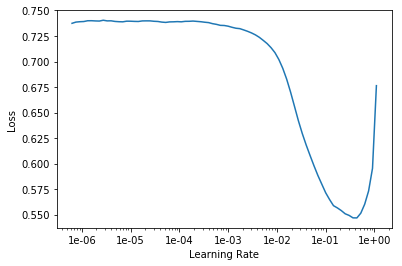

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.255265,0.231265,0.905303,03:46
1,0.230173,0.219532,0.909916,03:46
2,0.216697,0.203843,0.916354,03:44
3,0.203903,0.190965,0.922028,03:46
4,0.195965,0.186854,0.923617,03:46


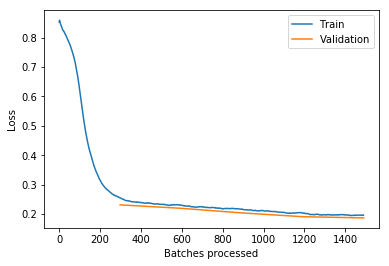

In [0]:
learn.save('res_streetstyle_crop_loss_res18_01')
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


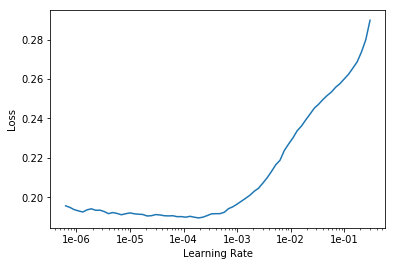

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.load('res_streetstyle_crop_loss_res18_01')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.193338,0.186129,0.923514,03:56
1,0.190657,0.183152,0.925000,03:56
2,0.188699,0.181248,0.925970,03:55
3,0.185631,0.180268,0.926455,03:55
4,0.183670,0.180386,0.926135,03:55


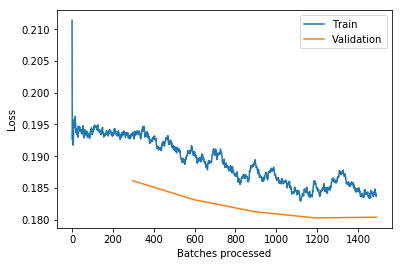

In [0]:
learn.recorder.plot_losses()

In [0]:
path = Path('/content/gdrive/My Drive/colab/model')
learn.save(path/'res_streetstyle_crop_loss_res18_02')
#learn.save('res_streetstyle_crop_loss_rn50_02')
learn = cnn_learner(data, ARCH, metrics=[accuracy_thresh])
learn.load(path/'res_streetstyle_crop_loss_res18_02')
print('loaded')

loaded


In [0]:
def get_cat_preds(probs, cats, data_classes):
    assert len(probs.shape) == 2
    idxs = get_cat_idxs(cats, data_classes)    
    return cats[probs[:, idxs].argmax(dim = 1)]
  
probs, ys = learn.get_preds(DatasetType.Valid)
val_labs = labels[labels['valid']].copy()
len(val_labs.index)

2423

Accuracy for clothing_pattern is 0.8679154658981748
Accuracy for major_color is 0.7335064935064936
Accuracy for sleeve_length is 0.7838565022421524
Accuracy for neckline_shape is 0.8071965628356605
Accuracy for clothing_category is 0.6756465517241379
Accuracy for multiple_layers is 0.8465196714223951
Confusion matrix, without normalization


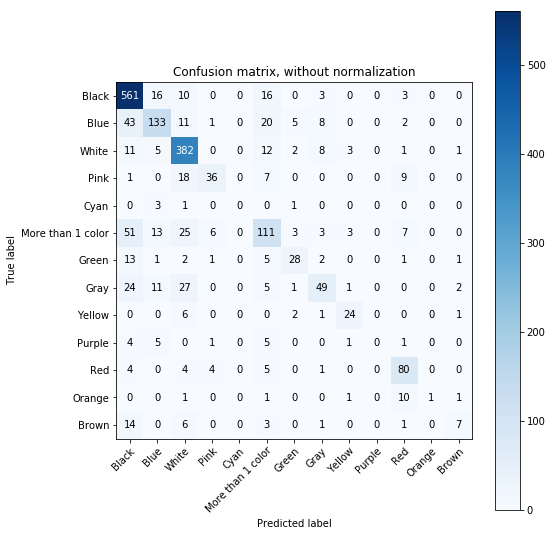

In [0]:
for cat_col in categories:
    
    cats = get_cats(val_labs, cat_col)
    val_labs['pred_'+cat_col] = get_cat_preds(probs, cats, learn.data.classes)
    
for cat_col in categories:
    na_rows = val_labs[cat_col].isna()
    acc = (val_labs.loc[~na_rows, 'pred_'+cat_col] == val_labs.loc[~na_rows, cat_col]).mean()
    print(f'Accuracy for {cat_col} is {acc}')
    
cat_col = 'major_color'
na_rows = val_labs[cat_col].isna()
plot_confusion_matrix(val_labs.loc[~na_rows, cat_col].apply(str), val_labs.loc[~na_rows, 'pred_'+cat_col].apply(str), figsize=(8, 8))

# Testing

In [0]:
learn_test = load_learner(path, test= ImageList.from_folder('data/cropped/test/'))
probs,ys = learn_test.get_preds(ds_type=DatasetType.Test)

test_labs = labels[labels['test']].copy()
test_labs = test_labs.drop_duplicates(subset='url', keep="first")
len(test_labs)

In [0]:
!ls 'data/cropped/test' | wc -l

2351


In [0]:
def get_cat_preds(probs, cats, data_classes):
    assert len(probs.shape) == 2
    idxs = get_cat_idxs(cats, data_classes)
    res = probs[:, idxs].argmax(dim = 1)
    #print(res)
    return cats[probs[:, idxs].argmax(dim = 1)]

preds = []
for cat_col in categories:
    cats = get_cats(test_labs, cat_col)
    pred = get_cat_preds(probs, cats, learn.data.classes)
    preds.append(pred)
    
preds = np.array(preds).transpose()
np.savetxt(path/"test.txt", preds, delimiter=',',fmt="%s")
#!ls '/content/gdrive/My Drive/colab/model'
    

Accuracy for clothing_pattern is 0.5697503671071953
Accuracy for major_color is 0.19617224880382775
Accuracy for sleeve_length is 0.44668192219679637
Accuracy for neckline_shape is 0.42825848849945236
Accuracy for clothing_category is 0.2040133779264214
Accuracy for multiple_layers is 0.5575221238938053
Confusion matrix, without normalization


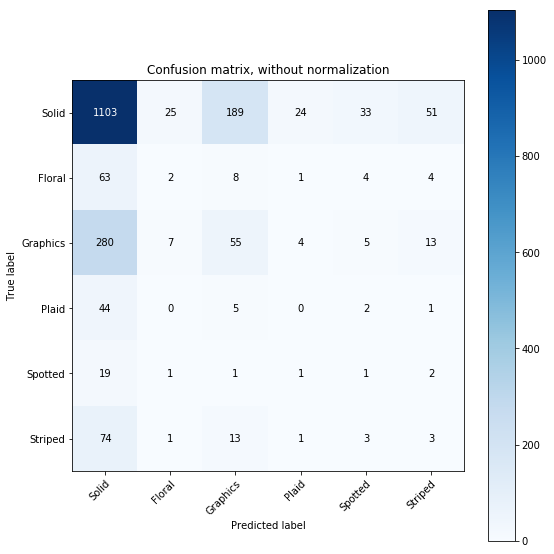

In [0]:
#use ResNet50
learn_test = load_learner('/content/gdrive/My Drive/colab/model/models', test= ImageList.from_folder('data/cropped/test/'))
probs,ys = learn_test.get_preds(ds_type=DatasetType.Test)
test_labs = labels[labels['test']].copy()

test_labs = test_labs.drop_duplicates(subset='url', keep="first")
for cat_col in categories:
    
    cats = get_cats(test_labs, cat_col)
    test_labs['pred_'+cat_col] = get_cat_preds(probs, cats, learn.data.classes)
    
for cat_col in categories:
    na_rows = test_labs[cat_col].isna()
    acc = (test_labs.loc[~na_rows, 'pred_'+cat_col] == test_labs.loc[~na_rows, cat_col]).mean()
    print(f'Accuracy for {cat_col} is {acc}')
    
cat_col = 'clothing_pattern'
na_rows = test_labs[cat_col].isna()
plot_confusion_matrix(test_labs.loc[~na_rows, cat_col].apply(str), test_labs.loc[~na_rows, 'pred_'+cat_col].apply(str), figsize=(8, 8))

Accuracy for clothing_pattern is 0.5580029368575624
Accuracy for major_color is 0.1850079744816587
Accuracy for sleeve_length is 0.4279176201372998
Accuracy for neckline_shape is 0.4419496166484118
Accuracy for clothing_category is 0.20066889632107024
Accuracy for multiple_layers is 0.5508849557522124
Confusion matrix, without normalization


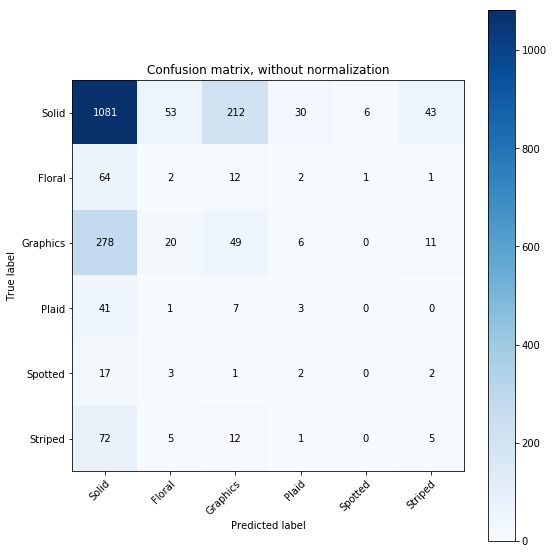

In [0]:
for cat_col in categories:
    
    cats = get_cats(test_labs, cat_col)
    test_labs['pred_'+cat_col] = get_cat_preds(probs, cats, learn.data.classes)
    
for cat_col in categories:
    na_rows = test_labs[cat_col].isna()
    acc = (test_labs.loc[~na_rows, 'pred_'+cat_col] == test_labs.loc[~na_rows, cat_col]).mean()
    print(f'Accuracy for {cat_col} is {acc}')
    
cat_col = 'clothing_pattern'
na_rows = test_labs[cat_col].isna()
plot_confusion_matrix(test_labs.loc[~na_rows, cat_col].apply(str), test_labs.loc[~na_rows, 'pred_'+cat_col].apply(str), figsize=(8, 8))

# Conclusion

We summarize our conclusions as belows:

1.   We find that the performace of ResNet50 and ResNet18 are not as good as that of ResNet34, but ResNet18's performance is almost compatible. 
2.   Attribute classification proved to be a very challenging task for certain attributes, but much more successful in classifying other attributes.
3.   Using the annotating images is better than using the origianl images.



# Next Steps

*   Continue to explore models with the updated dataset.
*   Seek better models(detection, segmentation and classification) to see how competitive it in the platform.ai
*   Discover temporal fashion patterns
*   Anotate images using Similar.ai labels.
